# Телекоммуникации. Прогноз оттока клиентов.

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Поставлена следующая задача: обучить на этих данных модель для прогноза оттока клиентов. Цель: получить прогнозную модель с высоким качеством.

# Оглавление:
---------------------------

1. [Загрузка библиотек и исходных данных](#1)  
2. [Предобработка данных](#2)  
3. [Исследовательский анализ данных](#3)  
4. [Объединение данных](#4)  
5. [Исследовательский анализ объединённых данных](#5)  
6. [Корреляционный анализ](#6)  
7. [Построение модели](#7)  
8. [Анализ значимости признаков](#8) 
9. [Общий вывод и рекомендации заказчику](#9)  
10. [Дополнительное задание: расчёт убытков](#10)

<a id="1"></a>

## Загрузка библиотек и данных

Начнём с загрузки и подключения библиотек:

In [1]:
!pip install shap==0.44.1
!pip install phik
!pip install scikit-learn==1.2.2
!pip install catboost==1.2.5
!pip install matplotlib==3.7.1

In [2]:
import os
import warnings
import pickle

import pandas as pd
import numpy as np

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn import set_config
from sklearn.metrics import f1_score, make_scorer, fbeta_score, precision_score, recall_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import (
    GridSearchCV, 
    train_test_split
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
    MinMaxScaler
)
from matplotlib import pyplot as plt
import datetime
import phik
import shap as shap
import seaborn as sns
from catboost import CatBoostClassifier


warnings.filterwarnings("ignore")
set_config(transform_output="pandas")

RANDOM_STATE = 200524 

Теперь загрузим исходные данные:

In [3]:
def check_and_read(path, index_col=None, parse_dates=None, info=True):
    if os.path.exists(path):
        data = pd.read_csv(path, index_col=index_col, parse_dates=parse_dates)
        if info:
            display(data.head())
            data.info()
            display(data.describe(include='all'))
        return data
    else:
        print(f'Не найден файл по указанному пути: {path}')

        
contract = check_and_read('datasets/contract_new.csv', index_col='customerID', parse_dates=['BeginDate', 'EndDate'])
client = check_and_read('datasets/personal_new.csv', index_col='customerID')
internet = check_and_read('datasets/internet_new.csv', index_col='customerID')
phone = check_and_read('datasets/phone_new.csv', index_col='customerID')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043.000000,7043
unique,NaN,67,3,2,4,NaN,6658
top,NaN,No,Month-to-month,Yes,Electronic check,NaN,
freq,NaN,5942,3875,4171,2365,NaN,11
mean,2017-04-30 13:01:50.918642688,NaN,NaN,NaN,NaN,64.761692,NaN
min,2013-10-01 00:00:00,NaN,NaN,NaN,NaN,18.250000,NaN
25%,2015-06-01 00:00:00,NaN,NaN,NaN,NaN,35.500000,NaN
50%,2017-09-01 00:00:00,NaN,NaN,NaN,NaN,70.350000,NaN
75%,2019-04-01 00:00:00,NaN,NaN,NaN,NaN,89.850000,NaN
max,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,118.750000,NaN


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


,gender,SeniorCitizen,Partner,Dependents
count,7043,7043.000000,7043,7043
unique,2,NaN,2,2
top,Male,NaN,No,No
freq,3555,NaN,3641,4933
mean,NaN,0.162147,NaN,NaN
std,NaN,0.368612,NaN,NaN
min,NaN,0.000000,NaN,NaN
25%,NaN,0.000000,NaN,NaN
50%,NaN,0.000000,NaN,NaN
75%,NaN,0.000000,NaN,NaN


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


,MultipleLines
count,6361
unique,2
top,No
freq,3390


Заметно, что количество записей в наборах данных варьируется примерно в диапазоне от 5500 до 7000. Явных пропусков не отмечено, но в глаза бросается тип **object** переменной *TotalCharges*, хотя по смыслу она должна быть числовой.     

<a id="2"></a>

## Предобработка данных

Убедимся в отсутствии явных пропусков, проверив их в каждом столбце каждого набора данных:

In [4]:
print('Пропуски по датасетам:')
print(contract.isna().sum())
print(client.isna().sum())
print(internet.isna().sum())
print(phone.isna().sum())

Пропуски по датасетам:
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
MultipleLines    0
dtype: int64


Как было отмечено при загрузке данных, столбец *TotalCharges* имеет нечисловой тип, а следовательно его необходимо проверить на наличие неявных пропусков и привести к числовому:

In [5]:
mask = pd.to_numeric(contract['TotalCharges'], errors='coerce').isna()
print(contract[mask]['TotalCharges'].unique())
contract[mask]

[' ']


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,


Из вывода понятно, что в 11 записях в столбце *TotalCharges* встречается значение пробела. Эти пропуски следует удалить и привести столбец к числовому типу:

In [6]:
contract = contract[~mask]
contract['TotalCharges'] = contract['TotalCharges'].astype('float')
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7032 non-null   datetime64[ns]
 1   EndDate           7032 non-null   object        
 2   Type              7032 non-null   object        
 3   PaperlessBilling  7032 non-null   object        
 4   PaymentMethod     7032 non-null   object        
 5   MonthlyCharges    7032 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 439.5+ KB


Также приведём столбец *SeniorCitizen* к типу **bool** вместо числового.

In [7]:
client['SeniorCitizen'].replace({0: False, 1: True}, inplace=True)

Теперь посмотрим на соотношение разорванных и действительных контрактов. Заметно, что последних гораздо больше:

[]

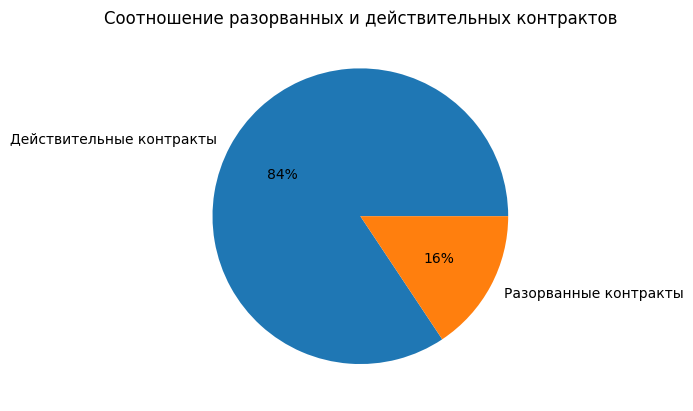

In [8]:
(contract['EndDate']=='No').replace({True: 'Действительные контракты', False: 'Разорванные контракты'}).value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Соотношение разорванных и действительных контрактов')
plt.ylabel('')
plt.plot()

Столбцы с датой окончания и начала договора заменим на бинарный столбец с указанием на то, разорван ли контракт (целевая переменная), столбец с количеством дней, прошедших с момента заключения договора, и столбец с длительностью договора:

In [9]:
target = 'Ended'
target_yes_name = 'Разорванные контракты'
target_no_name = 'Действительные контракты'

contract[target] = contract['EndDate']!='No'
contract.loc[~contract[target], 'EndDate'] = datetime.date(2020, 2, 1)
contract['EndDate'] = contract['EndDate'].astype('datetime64[ns]')
contract['DaysSinceBegin'] = contract['BeginDate'].dt.date.apply(lambda x: (datetime.date(2020, 2, 1)-x).days)
contract['Duration'] = (contract['EndDate'] - contract['BeginDate']).dt.days

contract.drop(['EndDate', 'BeginDate'], inplace=True, axis=1)

Наличие признака *DaysSinceBegin* может привести к утечке информации. Так, если произведение месячных затрат на число месяцев с момента заключения контракта (а оно легко получается из числа дней) заметно превышает общие расходы, то такой клиент уже некоторое время не платит абонентскую плату и, вероятно, расторг контракт. Проверим это предположение на графике:

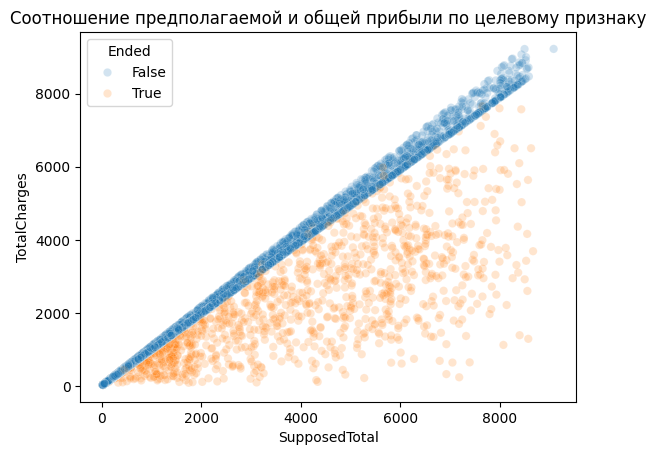

In [10]:
contract['SupposedTotal'] = contract['MonthlyCharges']*contract['DaysSinceBegin']//30
plt.title('Соотношение предполагаемой и общей прибыли по целевому признаку')
sns.scatterplot(x='SupposedTotal', y='TotalCharges', data=contract, hue=target, alpha=0.2)
plt.show()

Предположение подтвердилось, поэтому признак *DaysSinceBegin* и вспомогательный *SupposedTotal* стоит удалить:

In [11]:
contract.drop(['SupposedTotal', 'DaysSinceBegin'], axis=1, inplace=True)

По итогам предобработки явных пропусков не выявлено, исправлены типы переменных *SeniorCitizen* и *TotalCharges*, столбцы с датами *BeginDate* и *EndDate* заменены на целевой столбец *Ended* и столбец с длительностью договора *Duration*. Удалены 11 неявных пропусков в столбце *TotalCharges*.

<a id="3"></a>

## Исследовательский анализ

Проведём анализ имеющихся признаков: для числовых построим гистограмму, а для категориальных - круговую диаграмму. Видно, что месячные расходы для большой группы клиентов не превышают 30, а в остальном почти нормально распределены. Распределение общих расходов в целом имеет форму Пуассона и его плотность монотонно снижается, а длительность контракта имеет два пика -  заключённые недавно (примерно за последний год) и более 2000 дней назад. Касательно категориальных признаков, только тип оплаты и тип платежа имеют 3 и 4 категории сответственно; остальные признаки бинарны. Аномалий среди значений и их частот не обнаружено.

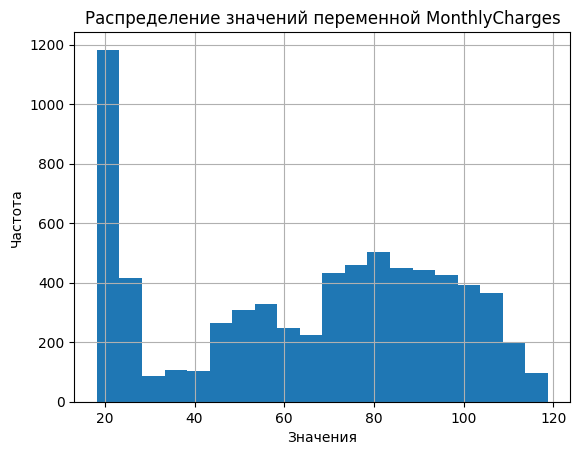

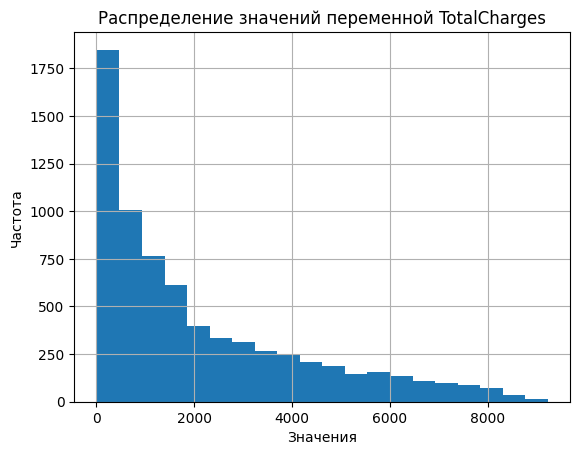

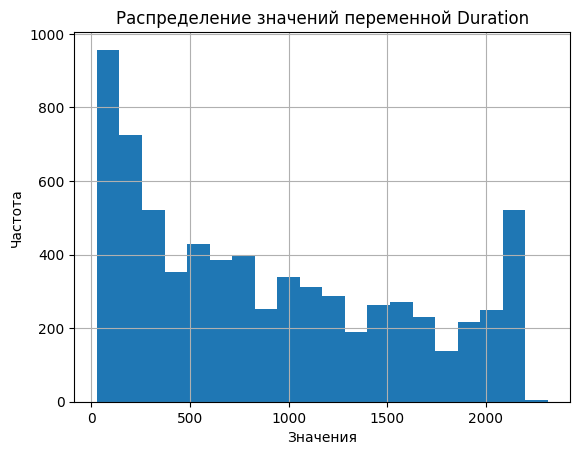

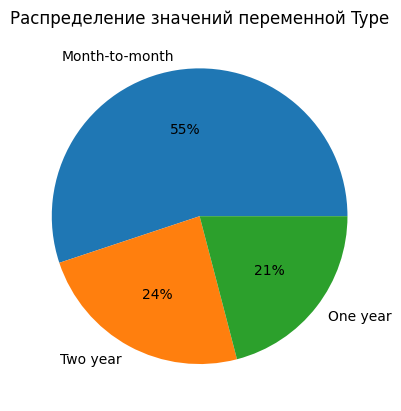

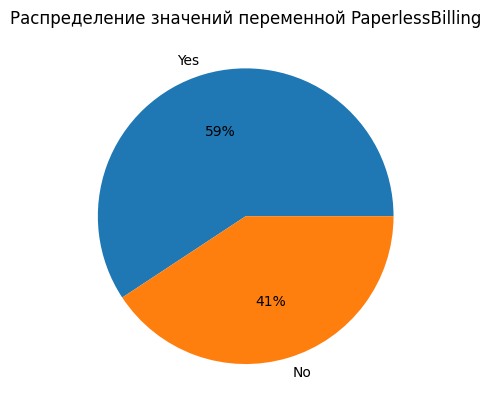

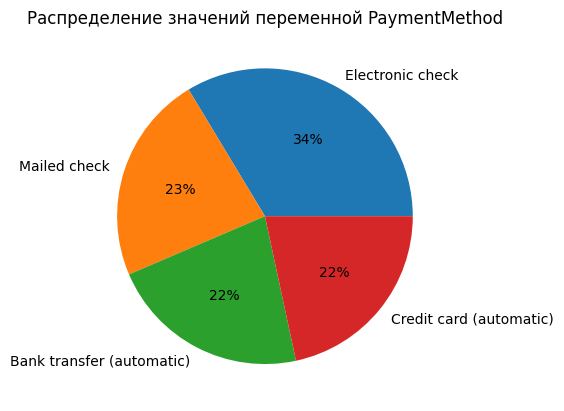

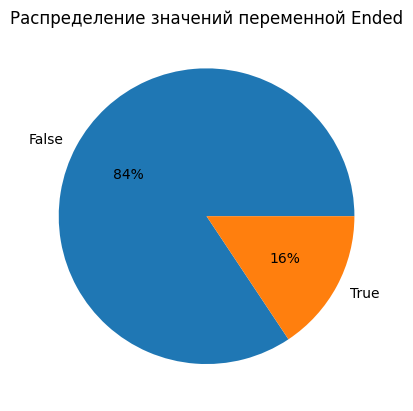

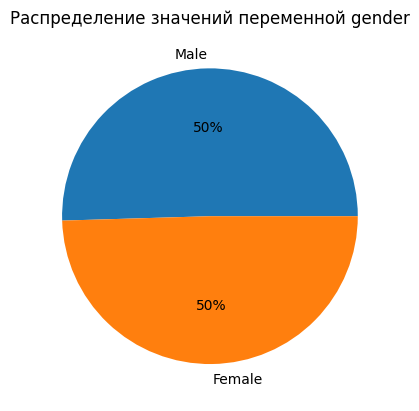

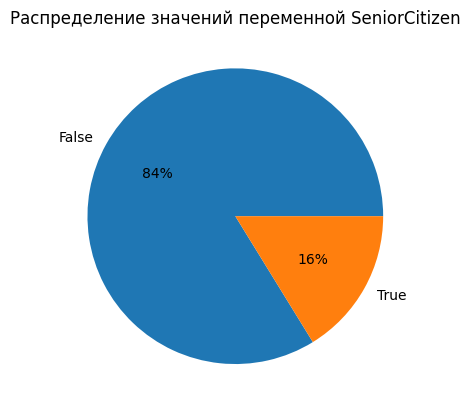

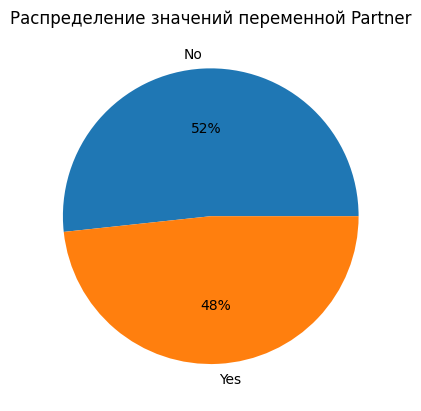

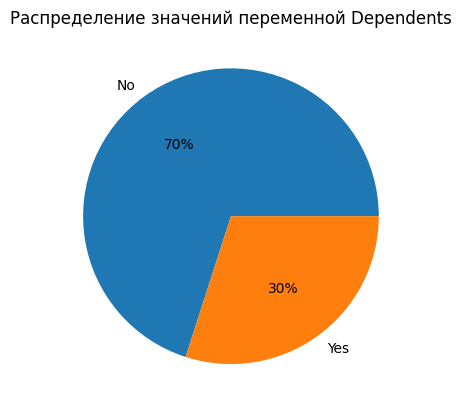

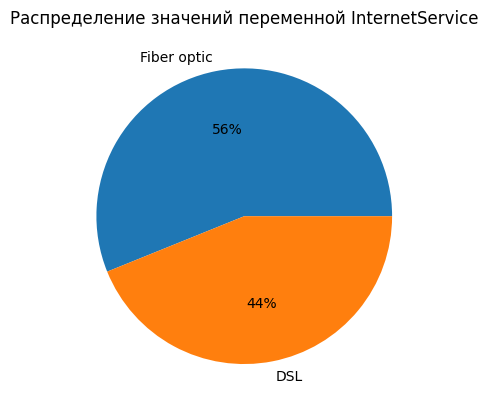

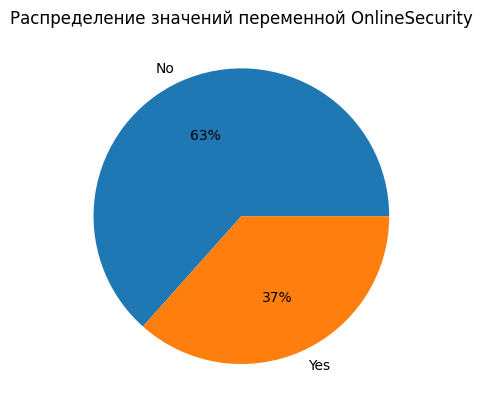

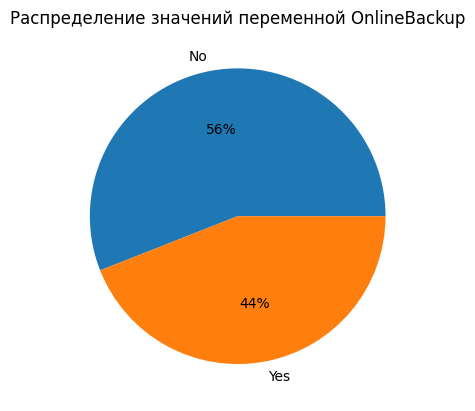

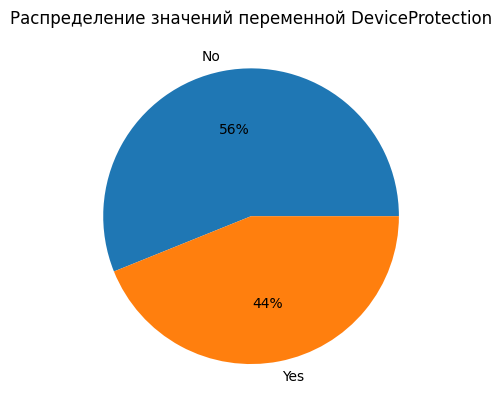

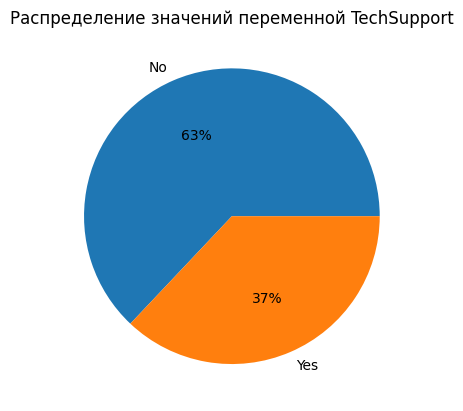

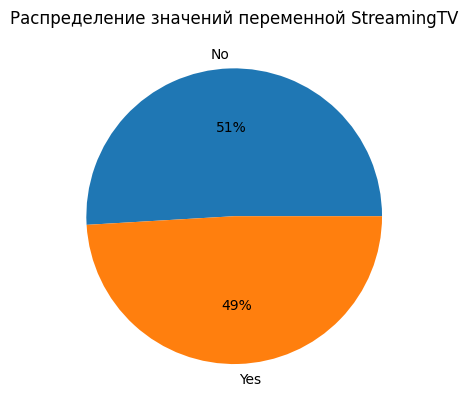

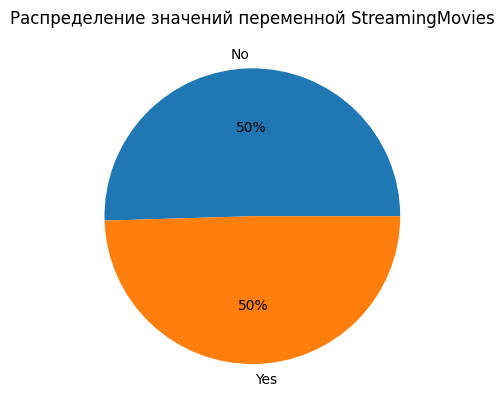

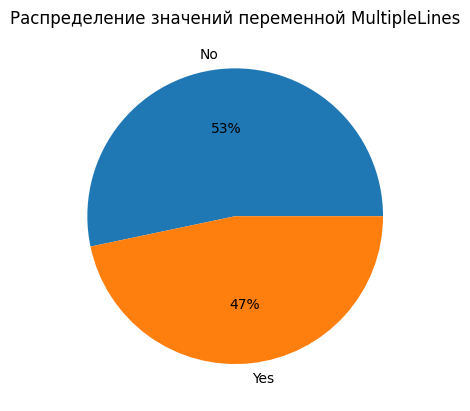

In [12]:
def draw(df):
    for name in df.select_dtypes(include=[np.number]).columns:
        df[name].hist(bins=20)
        plt.title(f'Распределение значений переменной {name}')
        plt.xlabel('Значения')
        plt.ylabel('Частота')
        plt.show()
    for name in df.select_dtypes(['object', 'bool']).columns:
        df[name].value_counts().plot(kind='pie', autopct='%1.0f%%')
        plt.title(f'Распределение значений переменной {name}')
        plt.ylabel('')
        plt.show()
    
    
for df in [contract, client, internet, phone]:
    draw(df)

Добавим анализ признаков в разрезе целевой переменной: для числовых построим сравнительный график плотности для разорванных и действительных контрактов, а для категориальных - круговую диаграмму для каждого из этих двух значений. В целом, заметно, что среди разорванных контрактов чаще встречаются клиенты с высокими месячными расходами (это логично, возможно, они ищут более дешёвых цен), а наиболее высокие и наиболее низкие значения общих расходов чаще свойственны для действующих контрактов (что соответствует недавно заключённым контрактам, которые ещё не успели расторгнуть, и группе наиболее лояльных клиентов). Распределение признака *Duration*  имеет схожий характер с общими расходами: два пика по краям для действующих контрактов и пик в центре для разорванных контрактов в районе 1000 дней.
  
Среди категориальных переменных можно отметить, что клиенты в браке и пользующиеся дополнительными услугами (кроме резервного хранилища и антивируса) чаще расторгали контракт.

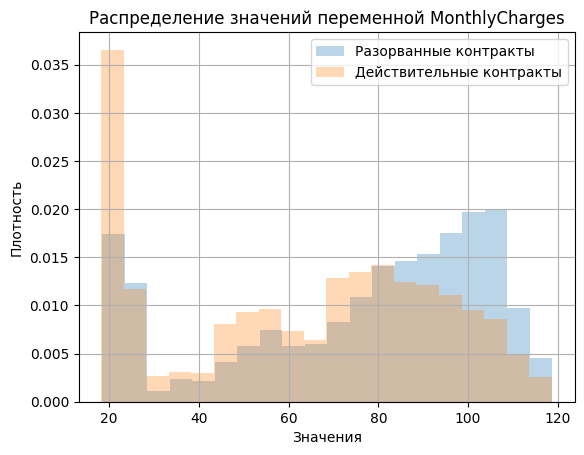

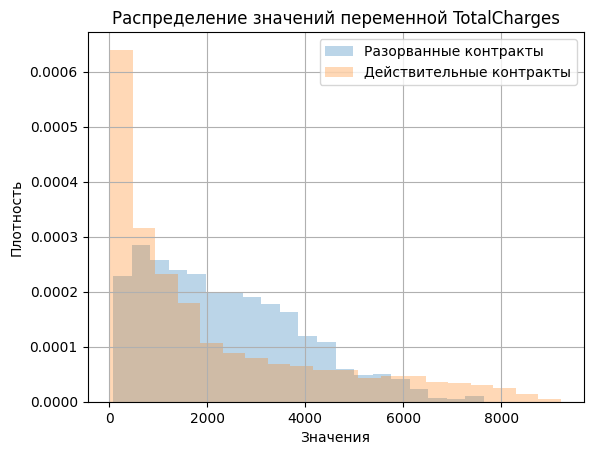

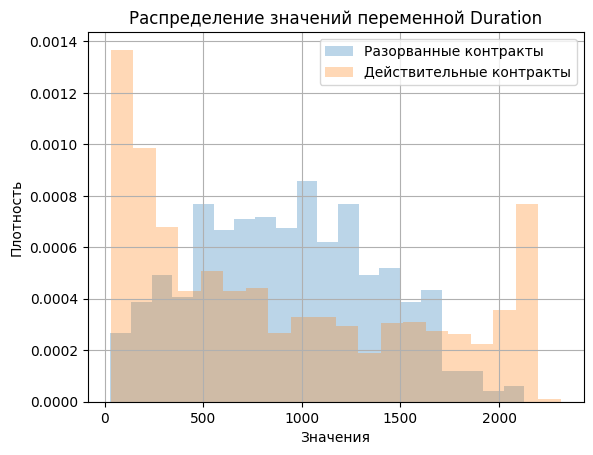

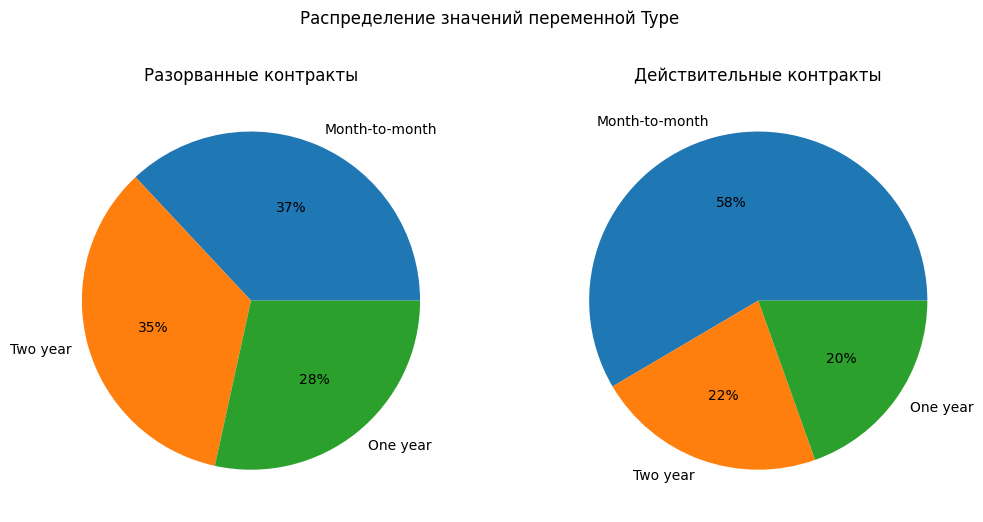

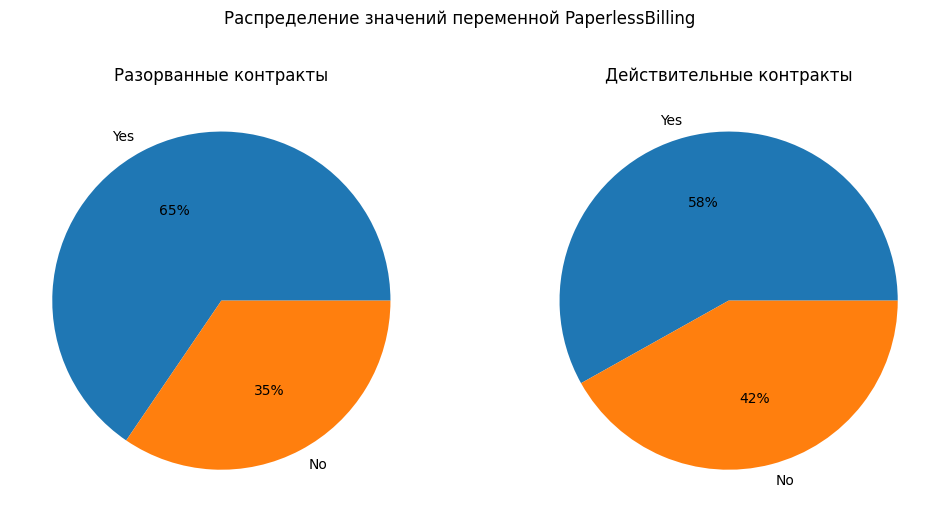

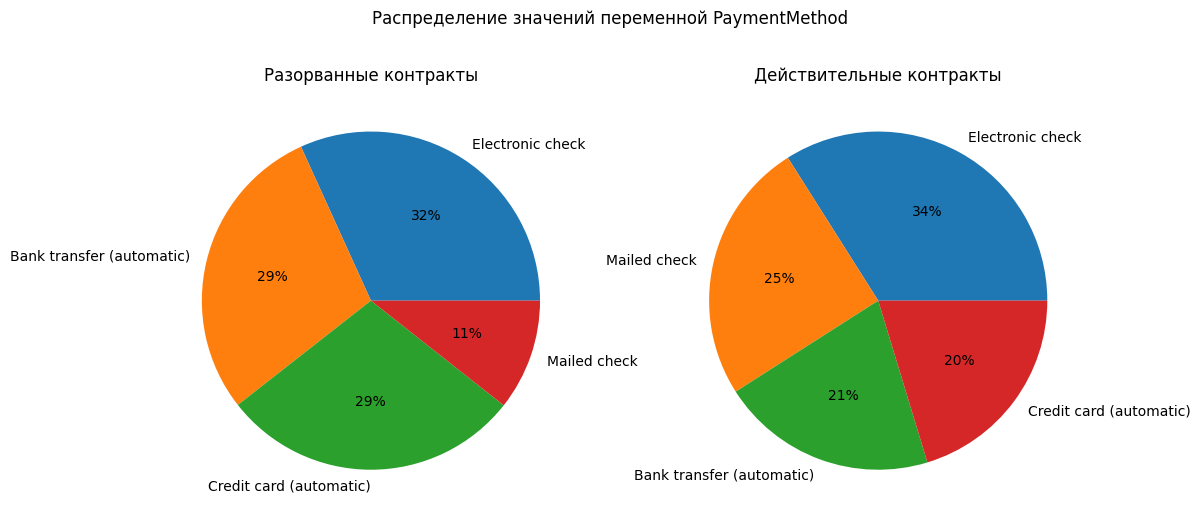

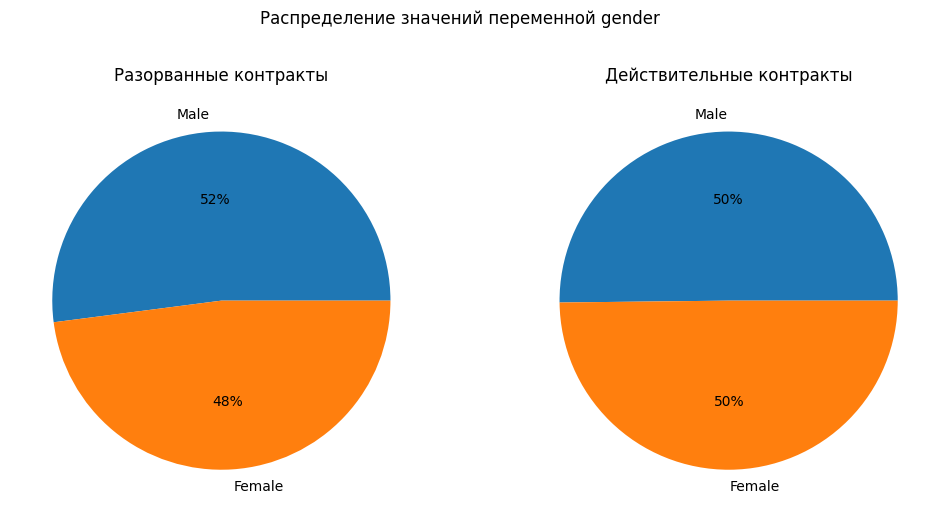

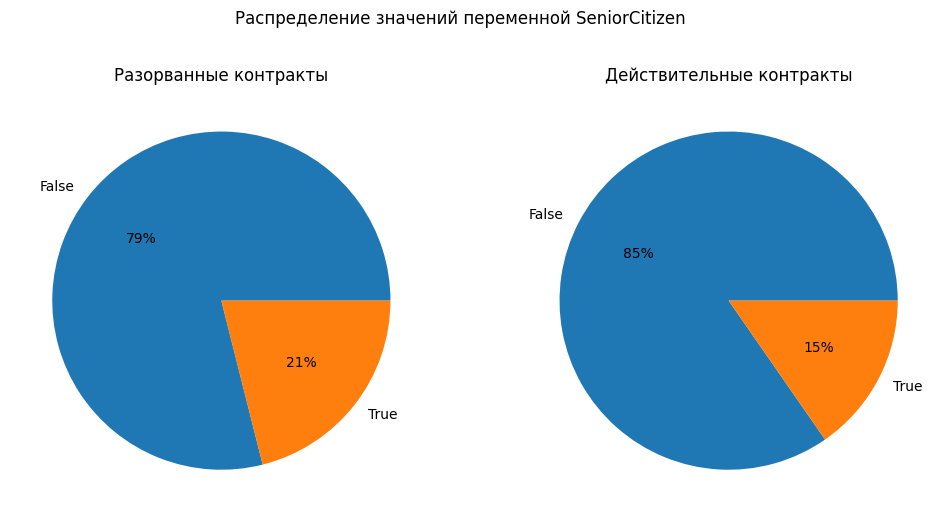

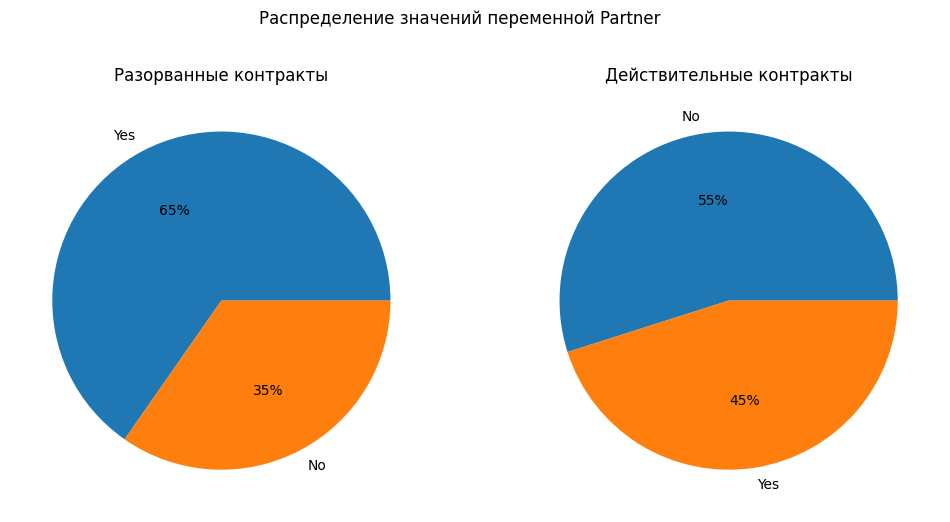

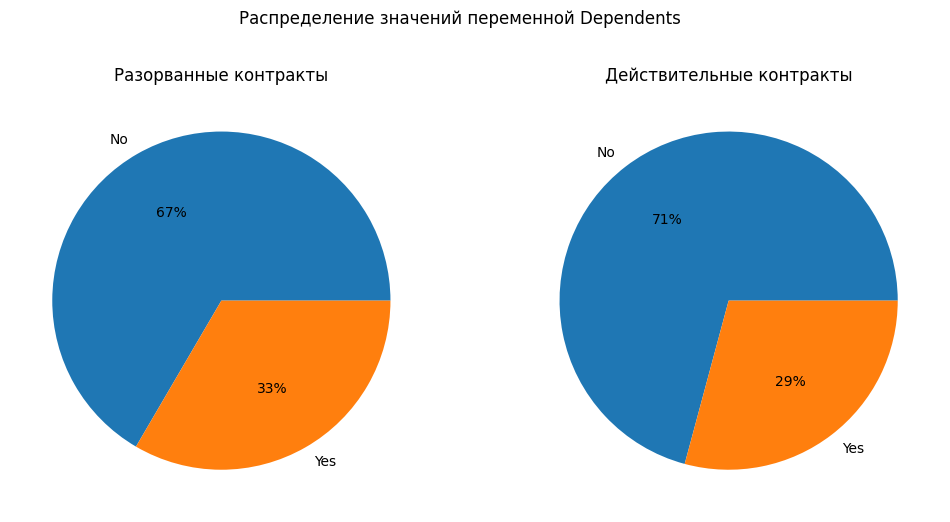

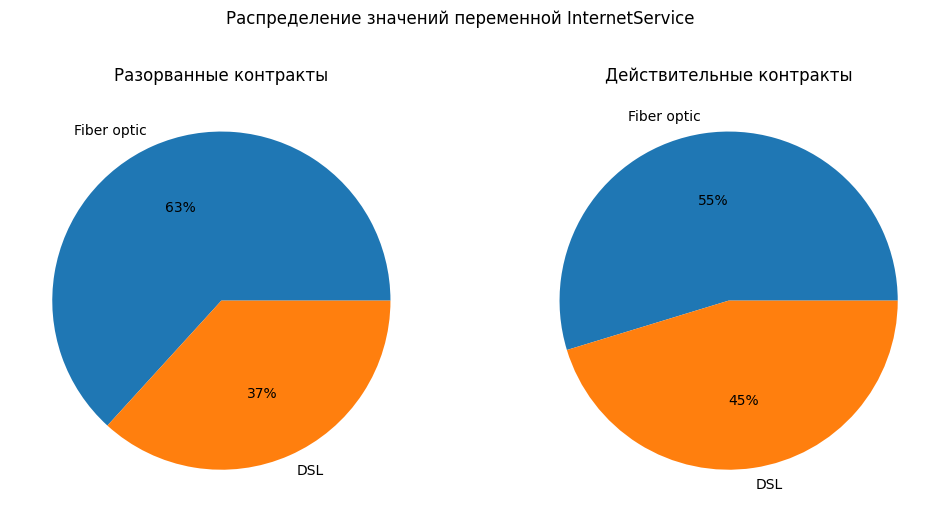

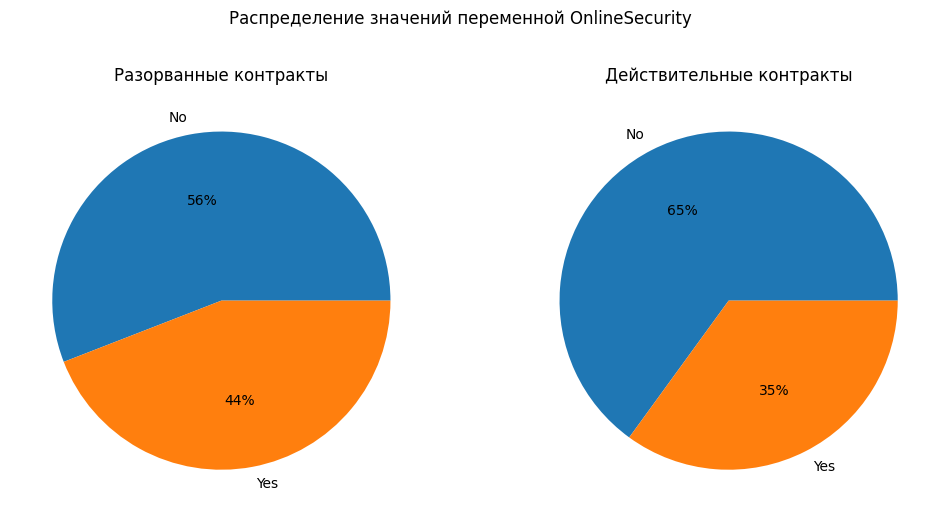

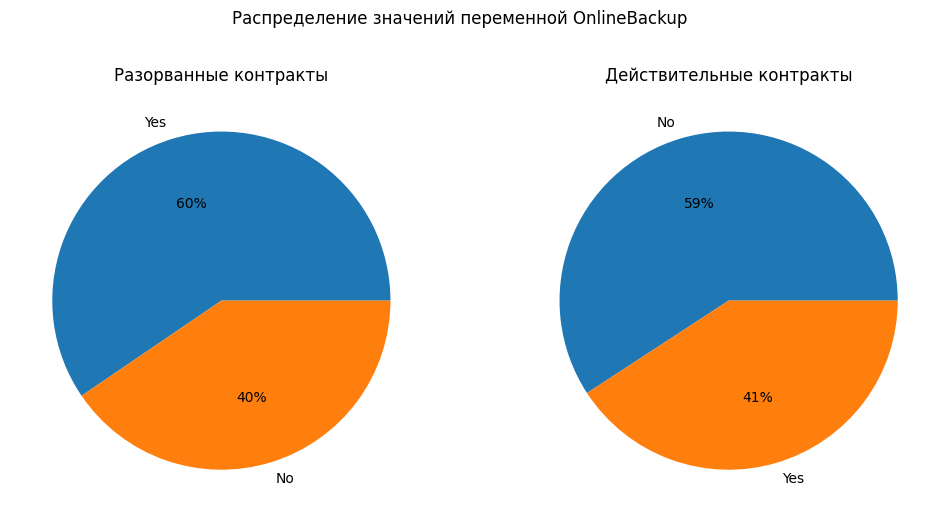

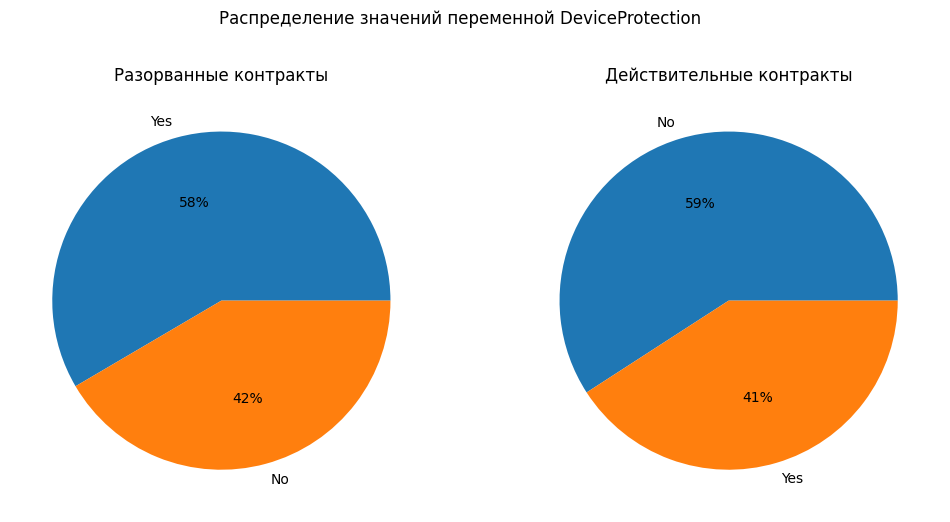

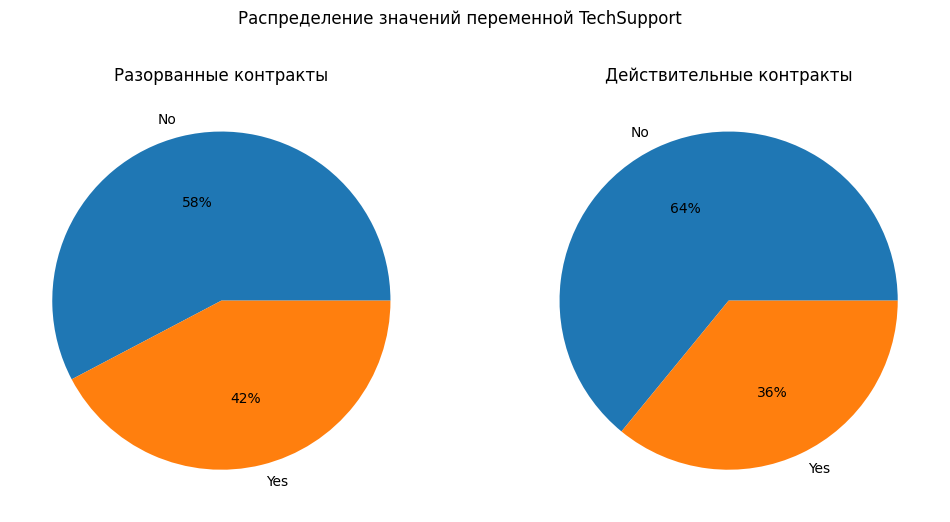

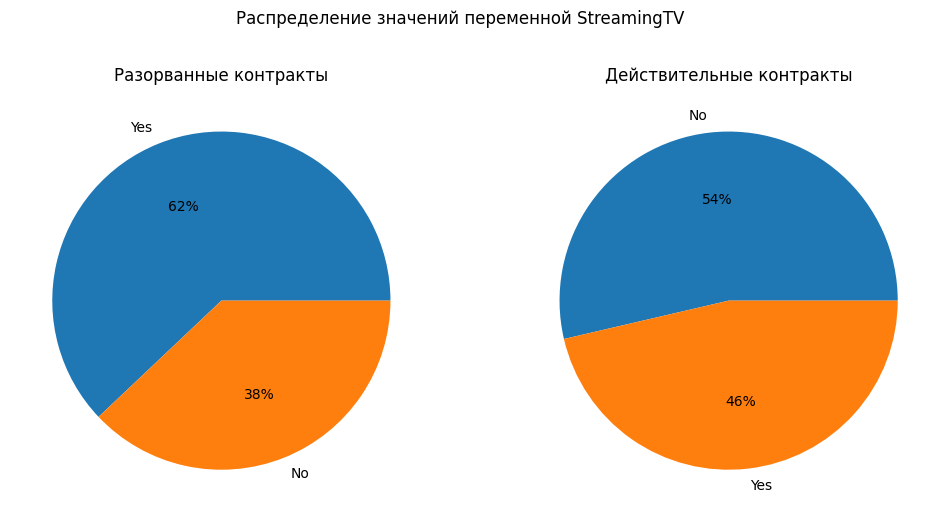

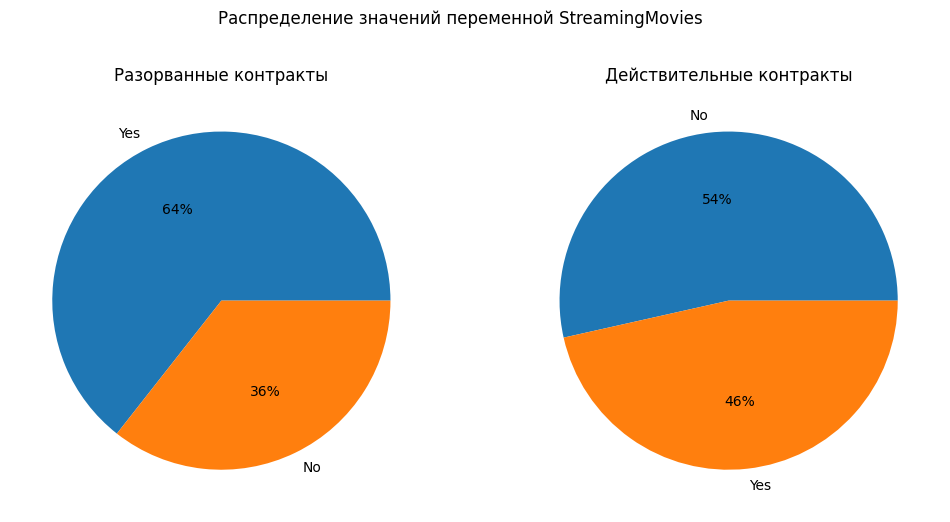

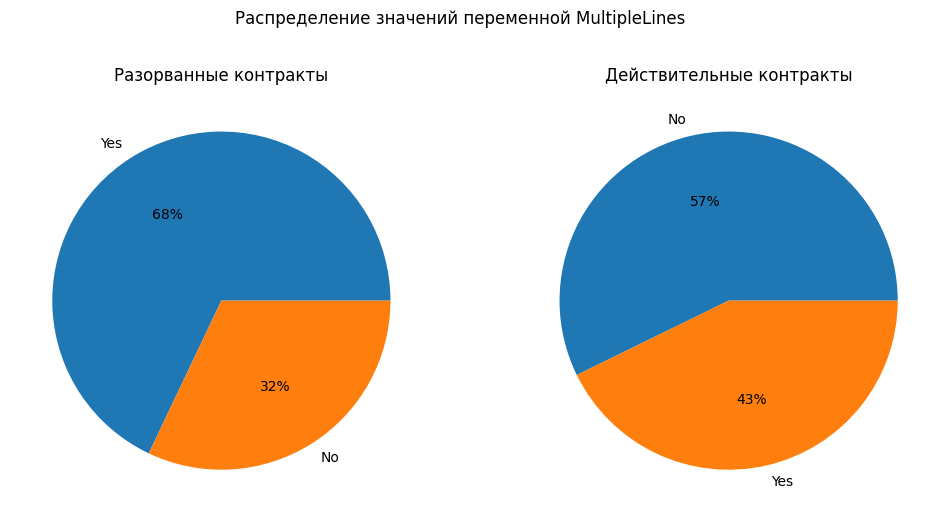

In [13]:
def draw_by_target(df, t_yes, t_no, target_yes_name, target_no_name):
    df1 = df.reindex(index=t_yes)
    df2 = df.reindex(index=t_no)
    for name in df.select_dtypes(include=[np.number]).columns:
        df1[name].hist(bins=20, density=True, alpha=0.3)
        df2[name].hist(bins=20, density=True, alpha=0.3)
        plt.title(f'Распределение значений переменной {name}')
        plt.legend([target_yes_name, target_no_name])
        plt.xlabel('Значения')
        plt.ylabel('Плотность')
        plt.show()
    for name in df.select_dtypes(['object', 'bool']).columns:
        figure, (axis1, axis2) = plt.subplots(1, 2, figsize=(12, 6)) 
        figure.suptitle(f'Распределение значений переменной {name}')
        df1[name].value_counts().plot(kind='pie', autopct='%1.0f%%', ax=axis1)
        axis1.set_title(target_yes_name)
        axis1.set_ylabel('')
        df2[name].value_counts().plot(kind='pie', autopct='%1.0f%%', ax=axis2)
        axis2.set_title(target_no_name)
        axis2.set_ylabel('')
        plt.show()
        
        
t_yes = contract[contract[target]].index
t_no = contract[~contract[target]].index
for df in [contract.drop(target, axis=1), client, internet, phone]:
    draw_by_target(df, t_yes, t_no, target_yes_name, target_no_name)

<a id="4"></a>

## Объединение данных

In [14]:
df = contract.join(client).join(internet).join(phone)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   Ended             7032 non-null   bool   
 6   Duration          7032 non-null   int64  
 7   gender            7032 non-null   object 
 8   SeniorCitizen     7032 non-null   bool   
 9   Partner           7032 non-null   object 
 10  Dependents        7032 non-null   object 
 11  InternetService   5512 non-null   object 
 12  OnlineSecurity    5512 non-null   object 
 13  OnlineBackup      5512 non-null   object 
 14  DeviceProtection  5512 non-null   object 
 15  TechSupport       5512 non-null   object 
 16  StreamingTV       5512 non-null 

Объединение прошло успешно, итоговый размер данных прежний: 7032. Вместе с тем, в присоединённых данных о телефонных и интернет-услугах есть пропуски, так как не у всех эти услуги подключены. Заменим эти пропуски заглушкой:

In [15]:
df.fillna('Not applicable', inplace=True)

<a id="5"></a>

## Исследовательский анализ объединённых данных

Проведём повторный анализ признаков в разрезе целевой переменной на объединённых данных. Свойства распределения интервальных переменных остались теми же. Касательно категориальных признаков, в их распределение добавилась новая категоря заглушки, но  в целом свойства только усилились: клиенты в браке и пользующиеся дополнительными услугами чаще расторгали контракт.

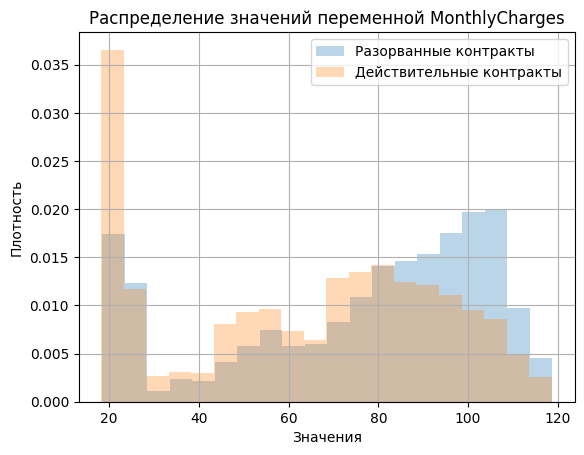

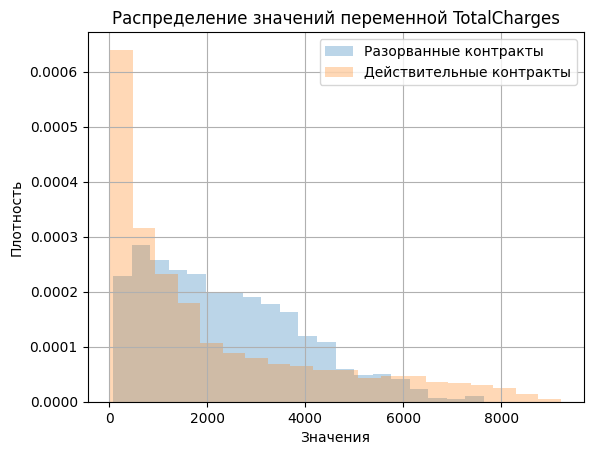

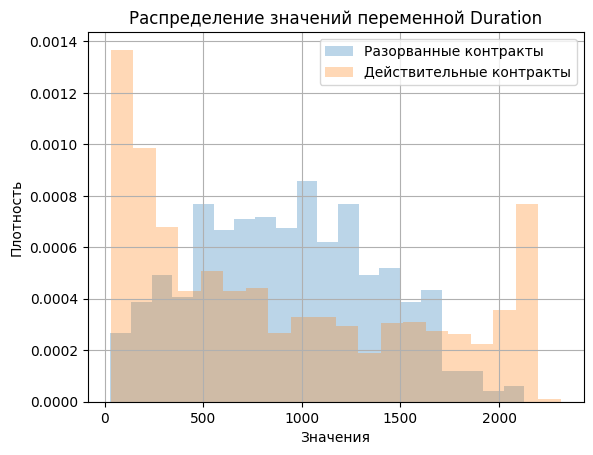

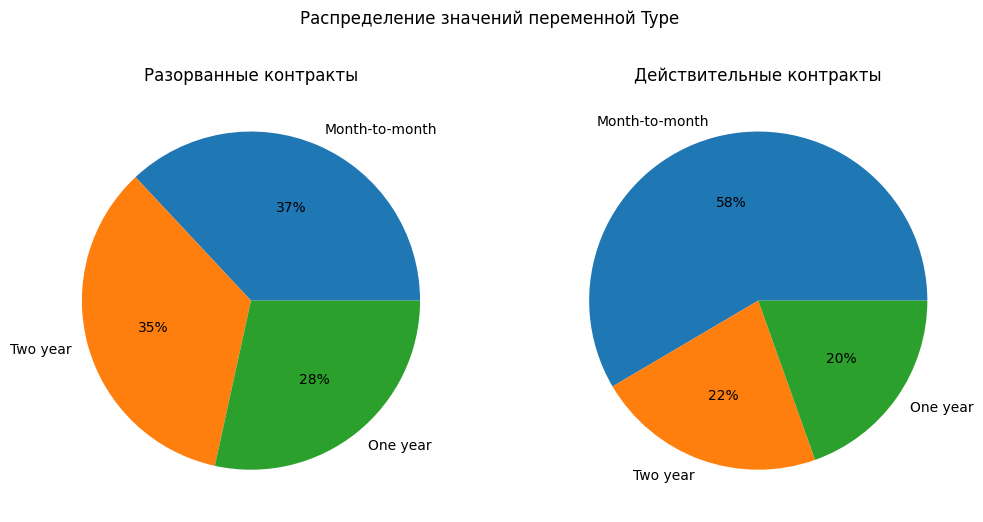

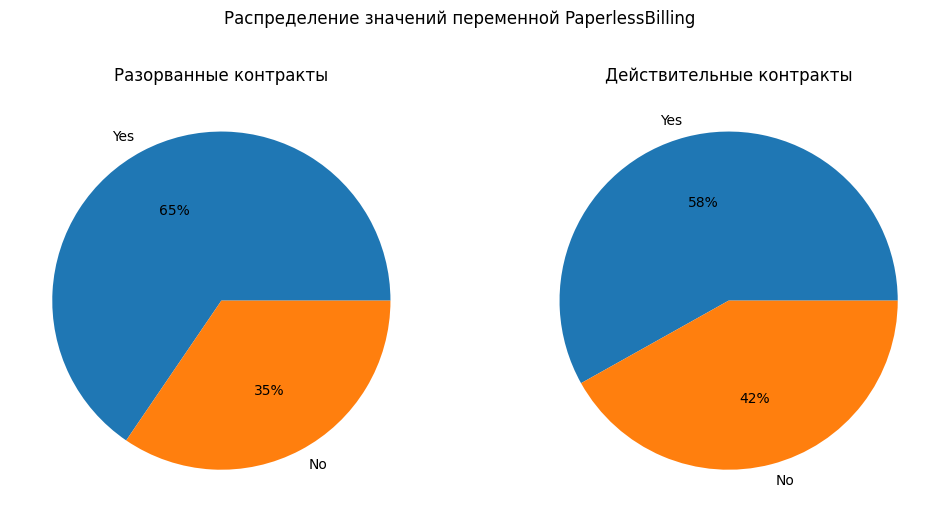

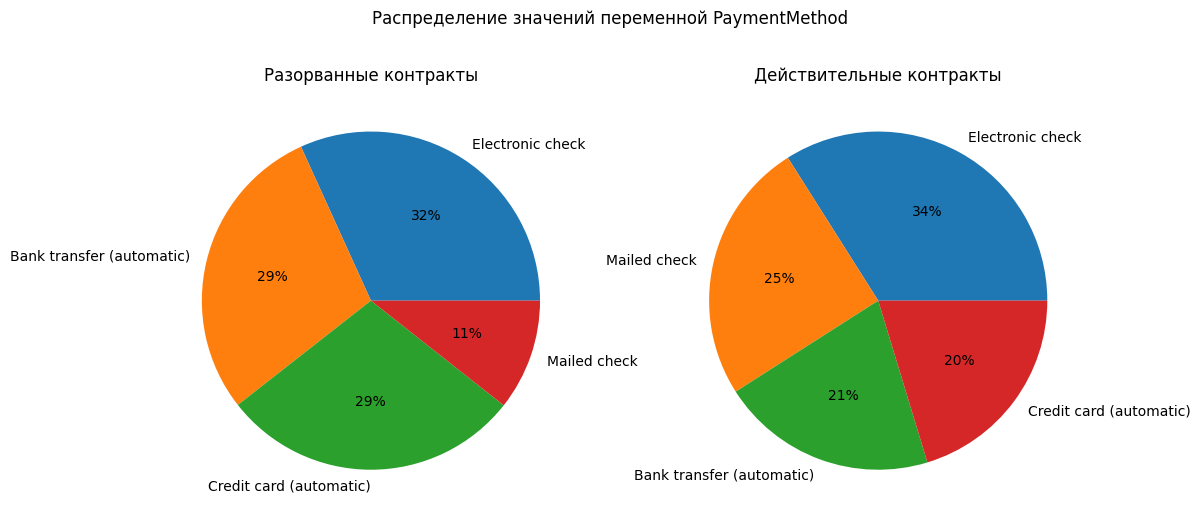

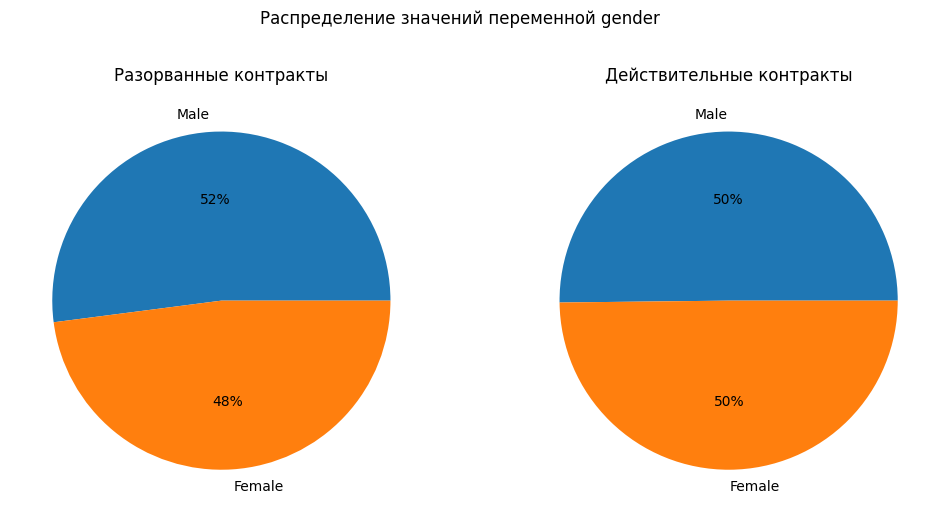

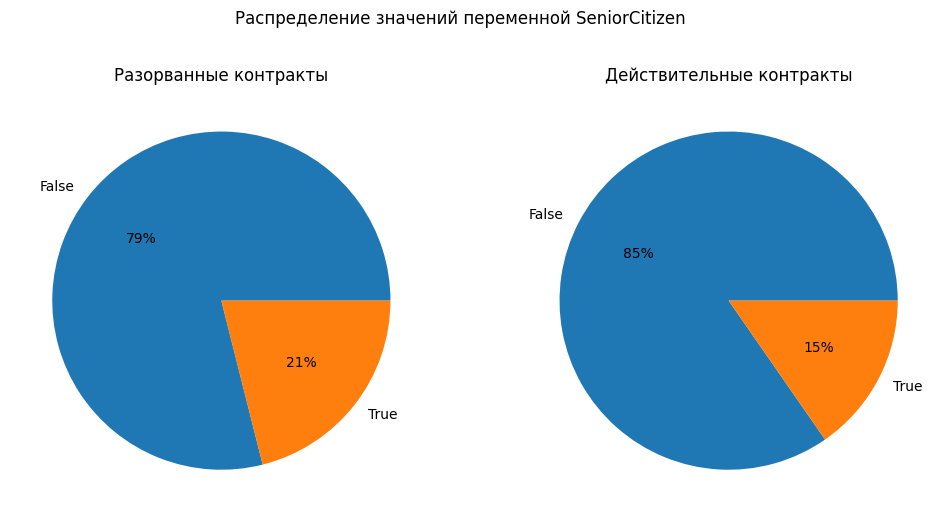

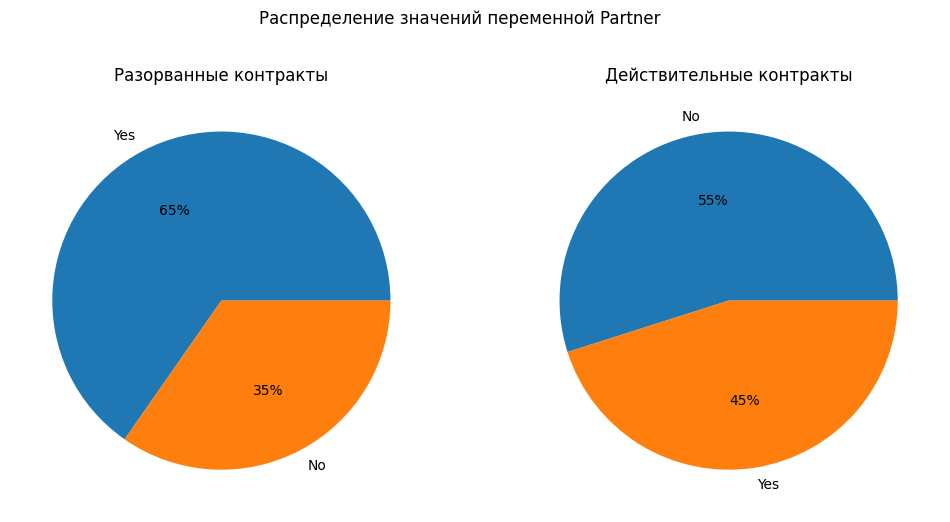

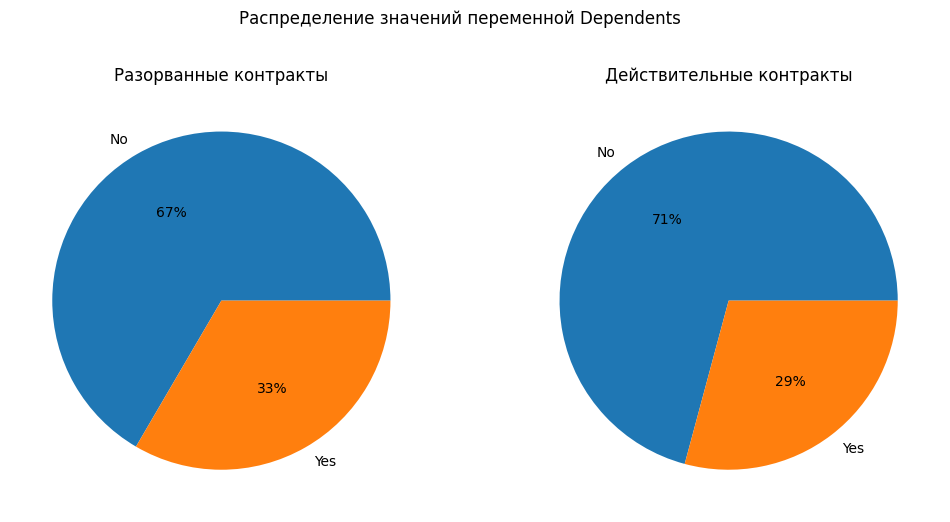

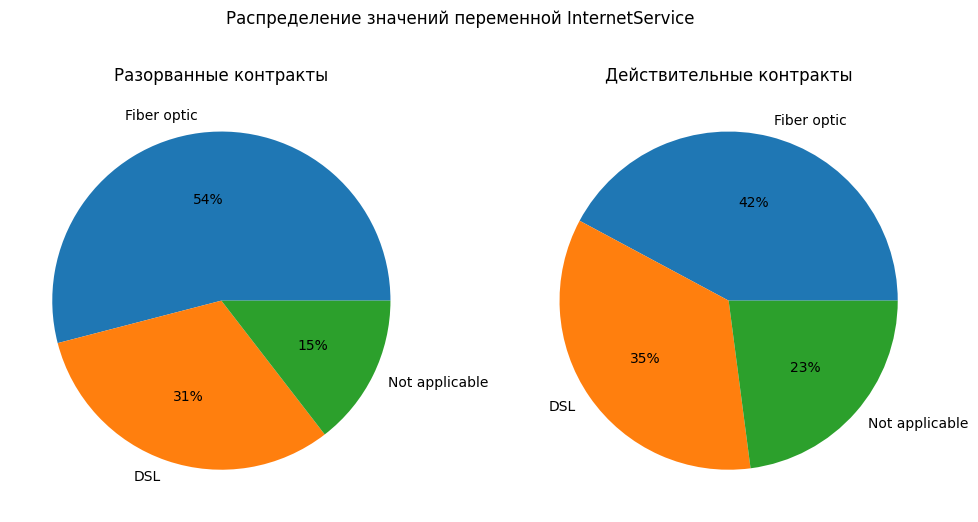

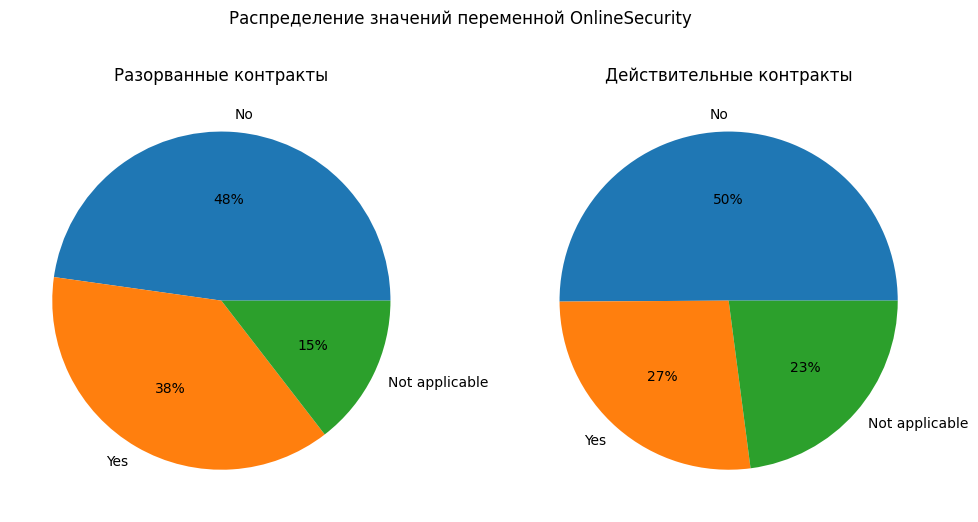

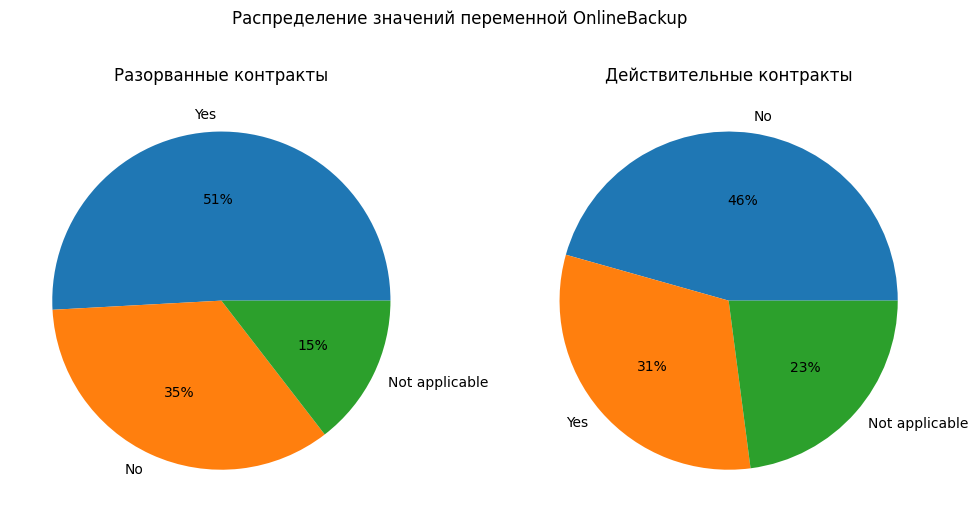

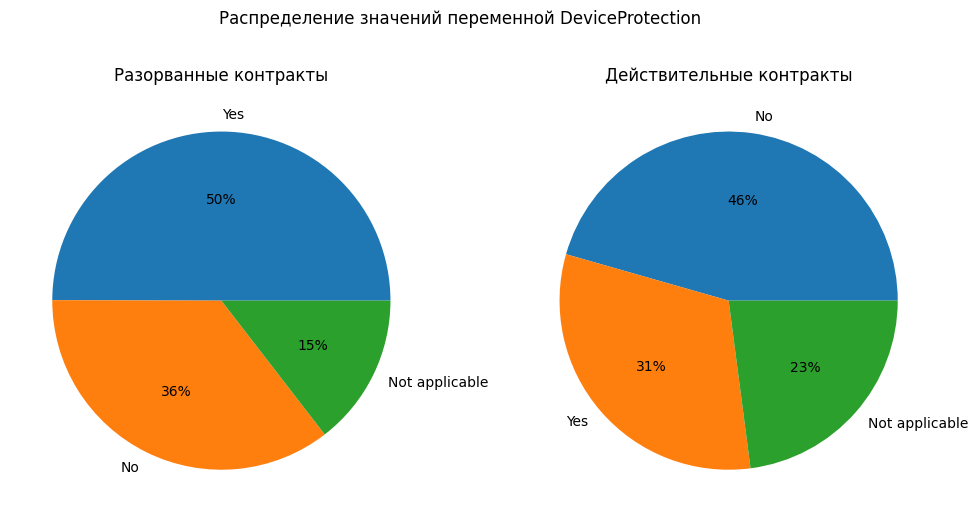

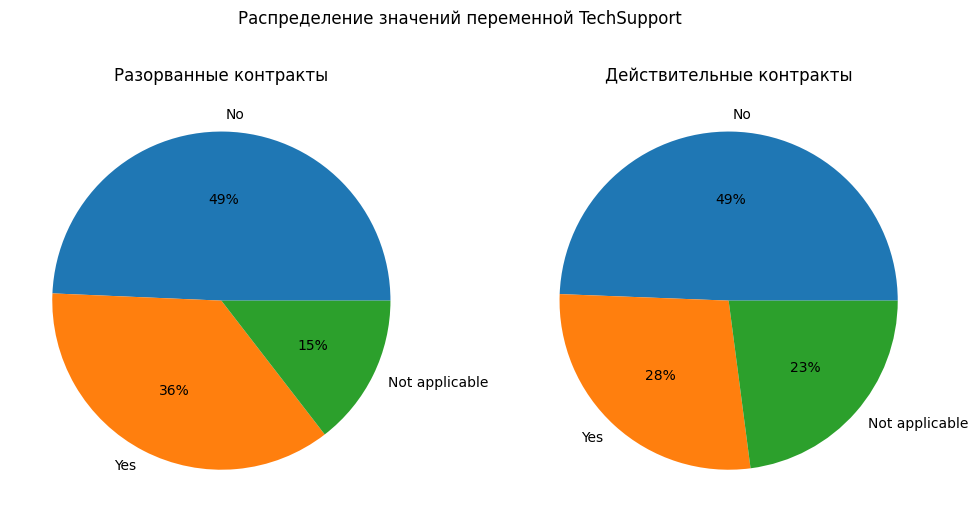

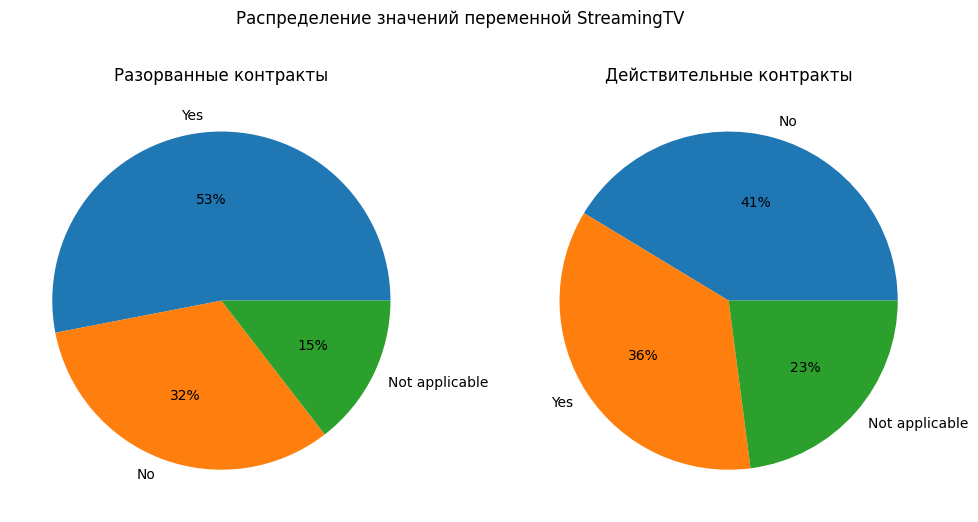

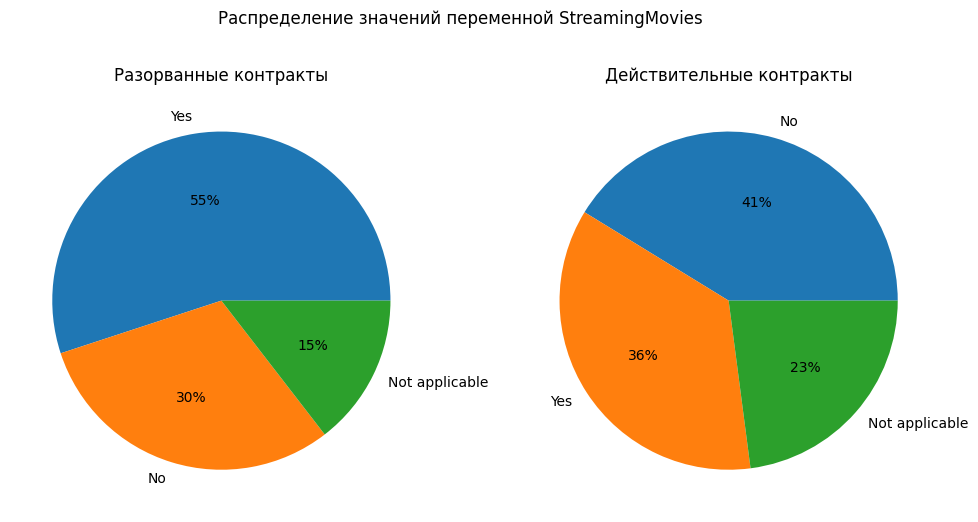

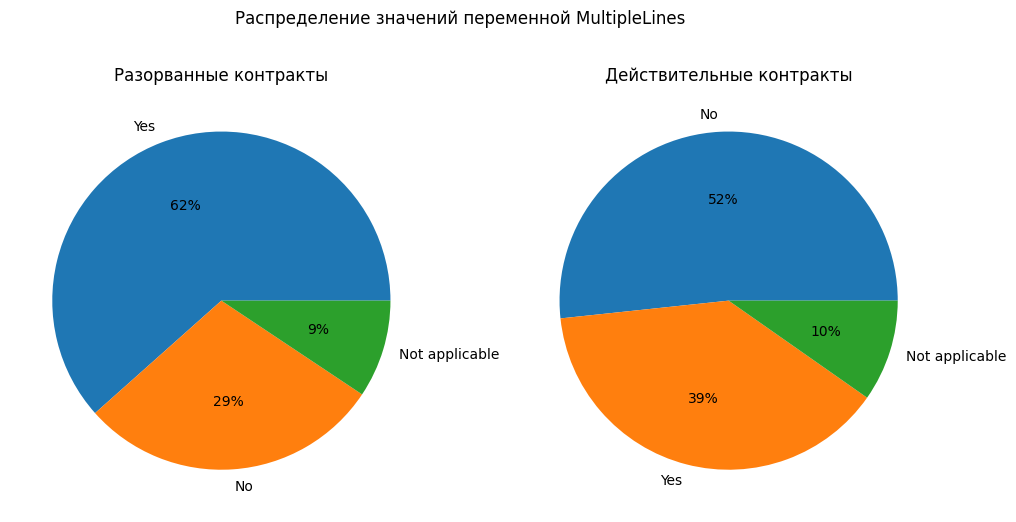

In [16]:
draw_by_target(df.drop([target], axis=1), t_yes, t_no, target_yes_name, target_no_name)

<a id="6"></a>

## Корреляционный анализ объединённых данных

Проведём корреляционный анализ с помощь. метода phik, так как признаки имеют смешанный характер (числовые и категориальные). 

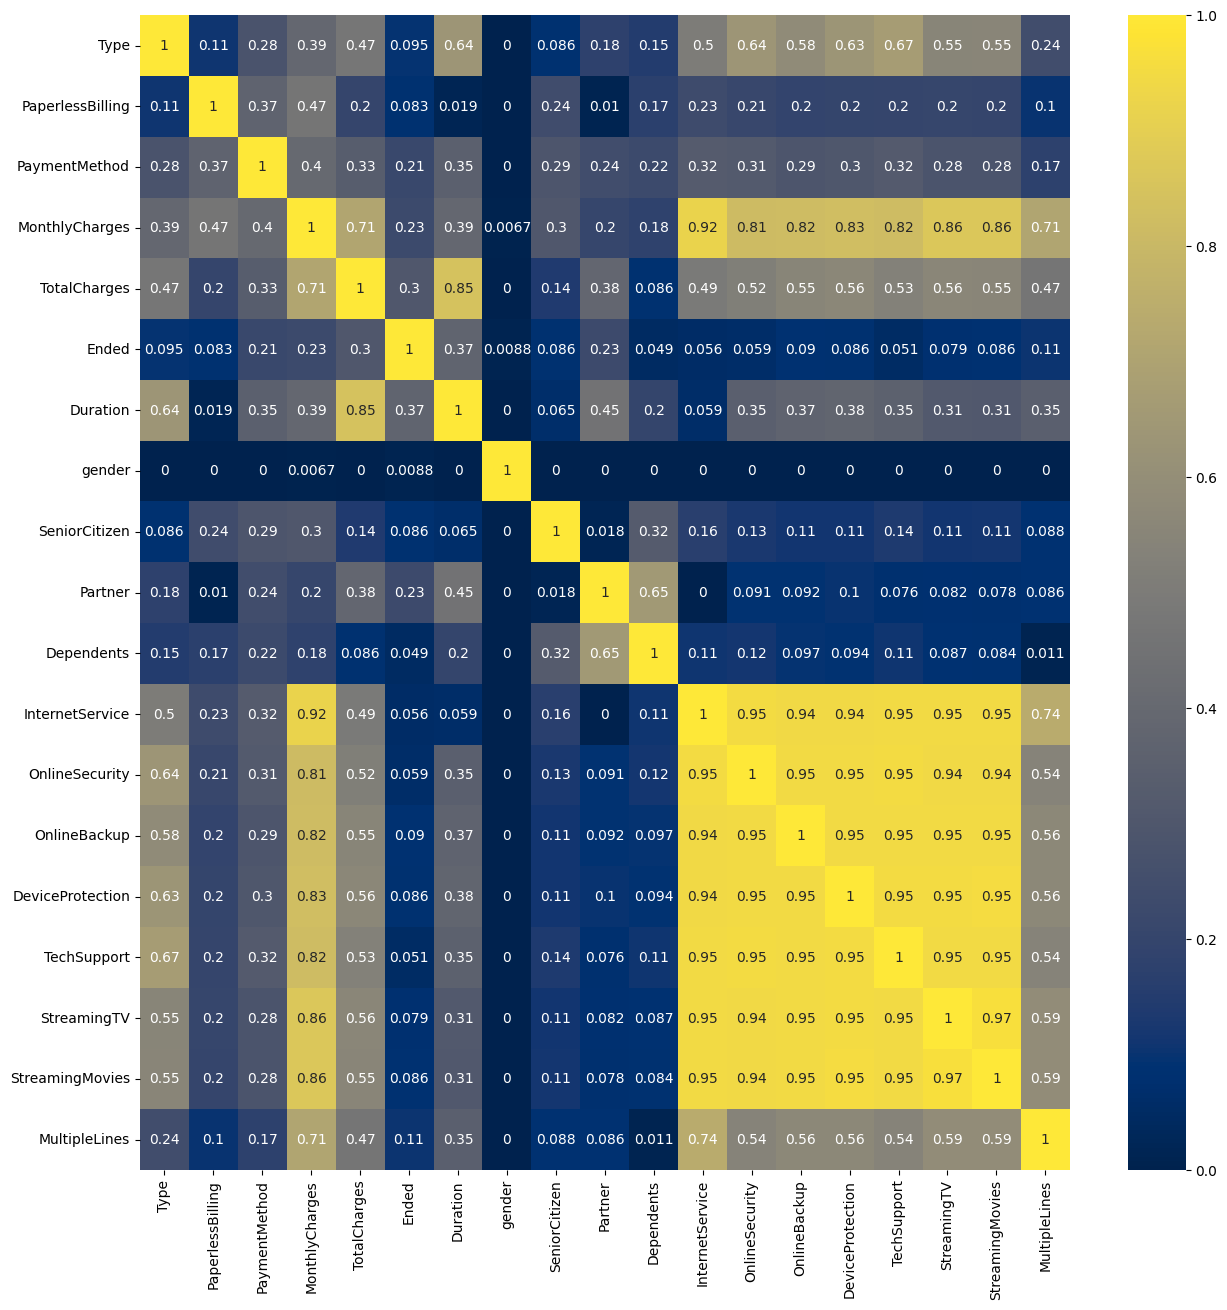

In [17]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'Duration']), annot=True, cmap='cividis')
plt.show()

Прежде всего, стоит отметить, что корреляция между столбцами с интернет-услугами заметно завышена (0,94), так как для всех клиентов без интернет услуг там стоит одно значение. Помимо этого, можно отметить, что столбец с месячными затратами ожидаемо коррелирует с наличием различных услуг, влияющих на абонентскую плату. В особенности это проявляется для наличия интернет-подключения (0,92), стримингового телевидения и кино (0,86). Также признак общей суммы затрат довольно сильно коррелирует с длительностью контракта (0,85) и месячными расходами (0,71); эти же три признака сильнее прочих коррелируют с целевым (0,3; 0,37; 0,23 соответственно). Так же уровень корреляции в 0,23 с целевым признаком присутствует у столбца *Partner*. Однако в целом имеющиеся категориальные признаки довольно слабо коррелируют с целевым признаком (с коэффициентом 0,23 и менее), что подтверждалось и на этапе исследовательского анализа. Признак *gender* вообще ни с чем не коррелирует, особенно с целевым признаком, но пока не будем ничего удалять.

<a id="7"></a>

## Построение модели

Перед построением модели закодируем целевой признак, выведем словарь преобразований и разделим выборку на тренировочную и тестовую:

In [18]:
le = LabelEncoder()
df[target] = le.fit_transform(df[target])
print('Словарь преобразований:', dict(zip(le.classes_, le.transform(le.classes_))))

Словарь преобразований: {False: 0, True: 1}


In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.drop([target], axis=1), df[target], test_size=0.25, random_state=RANDOM_STATE)

Выделим числовые и категориальные столбцы:

In [20]:
ohe_features = X_train.select_dtypes(include=['object', 'bool']).columns.to_list()
num_features = X_train.select_dtypes(include='number').columns.to_list()

Создадим преобразователь столбцов:

In [21]:
col_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
        ohe_features
    ),
    (
        'scaler', 
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

Зададим решетку параметров. Решено протестировать 5 моделей: дерево, метод ближайших соседей, логистическую регрессию, метод опорных векторов и бустинг. По возможности указаны параметры модели, позволяющие учитывать дисбаланс классов: 

In [22]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 15),
        'models__class_weight': ['balanced', None],
        'models__min_samples_leaf': range(1, 11),
        'columntransformer__scaler': [RobustScaler()]
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [1, 2, 3, 11, len(X_train)*0.01],
        'models__metric': ['manhattan', 'euclidean'],
        'models__weights': ['uniform', 'distance'],
        'columntransformer__scaler': [StandardScaler(), RobustScaler()]
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, max_iter=10000)],
        'models__C': [0.01, 0.1, 1],
        'models__class_weight': ['balanced', None],
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['saga', 'liblinear', ],
        'columntransformer__scaler': [StandardScaler(), MinMaxScaler()],
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.2, 1, 5],
        'models__gamma': [0.02, 0.1, 0.5],
        'models__class_weight': ['balanced',],
        'models__kernel': ['rbf'],
        'columntransformer__scaler': [StandardScaler(), RobustScaler()],
    },
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=0, cat_features=ohe_features, loss_function='Logloss')],
        'models__depth': [2, 3],
        'models__iterations': [1200, 1500, 2000],
        'models__l2_leaf_reg': [0.2, 0.3],
        'models__learning_rate': [0.1, 0.2],
        'models__auto_class_weights': ['None', 'Balanced'],       
        'columntransformer__onehotencoder': ['passthrough'],
        'columntransformer__scaler': [RobustScaler()],
    },
]


Создадим пайплайн:

In [23]:
pipeline_model = make_pipeline(col_transformer, 'models')

Теперь поиском по решётке найдём лучшие гиперпараметры при кросс-валидации. В качестве метрики для оценки будем использовать **roc-auc**-меру в соответствии с заданием, хотя во многом **F1-мера** была бы показательнее, так как среди двух классов в соответствии с целью проекта явно выделяется один целевой, по успешности предсказания которого и стоит измерять успех:

In [24]:
hyper_search = GridSearchCV(
    pipeline_model, 
    param_grid=param_grid, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=3,
)

use_prev = True
filename = 'final_project_model.sav'
if use_prev:
    hyper_search = pickle.load(open(filename, 'rb'))
else:
    hyper_search.fit(X_train, y_train)
    pickle.dump(hyper_search, open(filename, 'wb'))

Посмотрим на оценку лучшей модели при кросс-валидации. Она составляет 0,93 и это выглядит хорошим результатом:

In [25]:
round(hyper_search.best_score_, 3)

0.928

Отобразим пайплан и выведем в текстовом виде полученную модель (метод бустинга) и подобранные параметры (**RobustScaler**; **l2_leaf_reg**=0,2; **learning_rate**=0,2; с 1200 деревьями, глубиной 2, без балансировки классов):

In [26]:
display(hyper_search.best_estimator_)
hyper_search.best_params_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  'passthrough',
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod', 'gender',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'MultipleLines']),
                                                 ('scaler', RobustScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'Duration'])],
                                   verbose_feature_names_out=False)),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x000002313EFCC390>)])

{'columntransformer__onehotencoder': 'passthrough',
 'columntransformer__scaler': RobustScaler(),
 'models': <catboost.core.CatBoostClassifier at 0x2313ef07f90>,
 'models__auto_class_weights': 'None',
 'models__depth': 2,
 'models__iterations': 1200,
 'models__l2_leaf_reg': 0.2,
 'models__learning_rate': 0.2}

Попробуем ещё немного улучшить результат через устранение неинформативных признаков. Для этого обратимся к **permutation importance**:

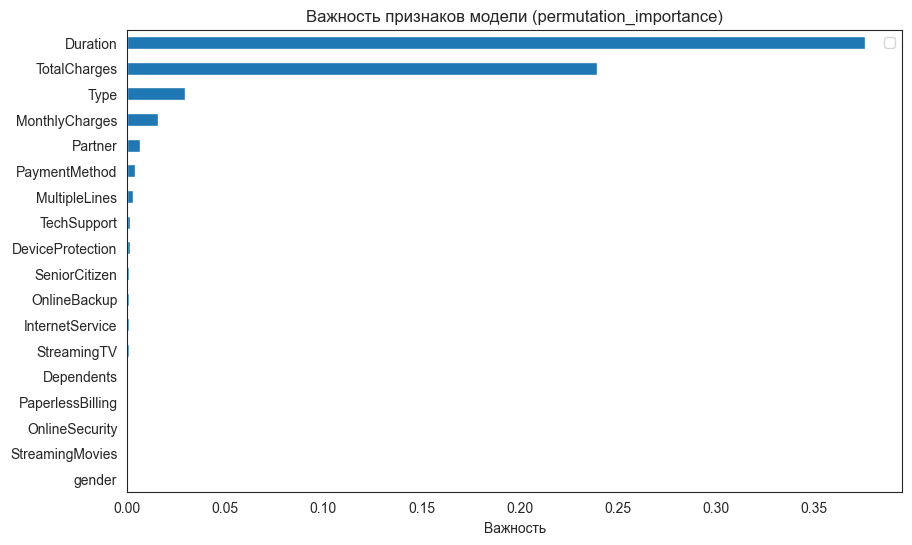

In [27]:
result = permutation_importance(hyper_search, X_train, y_train, scoring='roc_auc', n_repeats=15, random_state=RANDOM_STATE)
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': result['importances_mean']}).sort_values(
    'Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), legend=False)
plt.title('Важность признаков модели (permutation_importance)')
plt.xlabel('Важность')
plt.ylabel('')
plt.legend('')
plt.show()

Попробуем удалить 3 наименее важных признака: *gender*, *StreamingMovies*, *PaperlessBilling*:

In [28]:
df1 = df.drop(['gender', 'StreamingMovies', 'PaperlessBilling'], axis=1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(df1.drop([target], axis=1), df1[target], test_size=0.25, random_state=RANDOM_STATE)
ohe_features1 = X_train1.select_dtypes(include=['object', 'bool']).columns.to_list()
num_features1 = X_train1.select_dtypes(include='number').columns.to_list()

Подготовим данные и проведём кросс-валидацию модели **catboost** с теми же параметрами. :

In [29]:
col_transformer1 = make_column_transformer(
    (
        RobustScaler(), 
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [30]:
best_params = hyper_search.best_estimator_['models'].get_params()
best_params['cat_features'] = ohe_features1
model = CatBoostClassifier(**best_params)
cv_score = cross_val_score(model, col_transformer1.fit_transform(X_train1), y_train1, verbose=3, scoring='roc_auc').mean()
print(f'Метрика roc auc на кросс-валидации: {cv_score:.3f}')

[CV] END ................................ score: (test=0.915) total time=   6.9s
[CV] END ................................ score: (test=0.944) total time=   5.4s
[CV] END ................................ score: (test=0.921) total time=   5.6s
[CV] END ................................ score: (test=0.937) total time=   6.6s
[CV] END ................................ score: (test=0.919) total time=   6.1s
Метрика roc auc на кросс-валидации: 0.927


Результат на кросс-валидации стал незначительно хуже (0,927 против 0,927), так что вряд ли стоит ожидать улучшения оценки на тесте. Поэтому итоговую тестовую метрику высчитаем по изначальной модели:

In [31]:
y_pred = hyper_search.predict(X_test)
y_pred_proba = hyper_search.predict_proba(X_test)[:, 1]

print(f'Метрика roc auc на тестовой выборке: {roc_auc_score(y_test, y_pred_proba):.3f}')
print(f'Метрика f1 на тестовой выборке: {f1_score(y_test, y_pred):.3f}')
print(f'Метрика precision на тестовой выборке: {precision_score(y_test, y_pred):.3f}')
print(f'Метрика recall на тестовой выборке: {recall_score(y_test, y_pred):.3f}')

Метрика roc auc на тестовой выборке: 0.949
Метрика f1 на тестовой выборке: 0.794
Метрика precision на тестовой выборке: 0.940
Метрика recall на тестовой выборке: 0.687


Полученная оценка: **roc auc**=0,949. Результат хороший, дополнительные метрики показывают следующие значения: **F1**=0,794 при **precision**=0,940 и **recall**=0,687. Это означает, что классификация проходит в целом довольно качественно, но именно целевой признак предсказывется не столь хорошо (ошибка первого рода происходит с вероятностью примерно 31%).

На всякий случай, проведём проверку на адекватность через сравнение с примитивной моделью (равномерное распределение). Её результат **roc auc**=0,5 сильно уступает основной модели, а значит, тест пройден. Отдельно можно отметить, что дополнительная метрика **F1** для малопредставленного целевого класса даёт заниженные результаты (**F1**=0,236 против **roc auc**=0,5):

In [32]:
dummy = DummyClassifier(strategy='uniform', random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
dummy_pred_proba = dummy.predict_proba(X_test)[:, 1]

print(f'Метрика roc auc константной модели на тестовой выборке: {roc_auc_score(y_test, dummy_pred_proba):.3f}')
print(f'Метрика f1 константной модели на тестовой выборке: {f1_score(y_test, dummy_pred):.3f}')

Метрика roc auc константной модели на тестовой выборке: 0.500
Метрика f1 константной модели на тестовой выборке: 0.236


В рамках исследования полученной модели, попробуем подобрать оптимальный порог классификации на тестовом датасете в предположении, что показатели **FPR** и **TPR** одинаково важны:

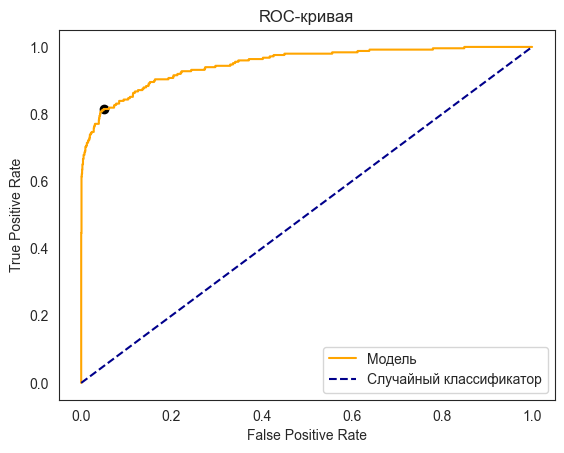

Оптимальный порог классификации: 0.257
FPR: 0.050
TPR: 0.815


In [33]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='Модель')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Случайный классификатор')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend()
    
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Оптимум')
    plt.show()
    
    print(f'Оптимальный порог классификации: {optimal_threshold:.3f}')
    print(f'FPR: {fpr[optimal_idx]:.3f}')
    print(f'TPR: {tpr[optimal_idx]:.3f}')
    return optimal_threshold

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)


thr = plot_roc_curve(fpr, tpr)

Полученные при оптимальном пороге значения **FPR** и **TPR**  указывают, что модель в пределе способна хорошо выявлять целевой класс (в 82,7 %). Найденный порог довольно мал (0,257), что является следствием несбалансированности целевой переменной, которая недостаточно учитывается моделью. Проверим, как при применении этого порога изменятся вспомогательные метрики:

In [34]:
y_pred = hyper_search.predict_proba(X_test)[:, 1]
y_pred = y_pred>=thr
print(f'Метрика f1 на тестовой выборке: {f1_score(y_test, y_pred):.3f}')
print(f'Метрика precision на тестовой выборке: {precision_score(y_test, y_pred):.3f}')
print(f'Метрика recall на тестовой выборке: {recall_score(y_test, y_pred):.3f}')

Метрика f1 на тестовой выборке: 0.770
Метрика precision на тестовой выборке: 0.730
Метрика recall на тестовой выборке: 0.815


Как и ожидалось, за повышение метрики **recall** (она же **TPR**)  приходится платить заметным снижением **precision**, отчего в целом **F1** несколько снижается.

<a id="8"></a>

## Анализ значимости признаков

Посмотрим на итоговую важность признаков *permutation importance* (уже на тесте). Два наиболее важных признака: длительность контракта и общие затраты. Заметно менее важны тип оплаты и месячные затраты . Из личных признаков относительно важно только то, состоит ли клиент в браке. Половина остальных признаков не имеет значимости вовсе, остальные едва значимы.

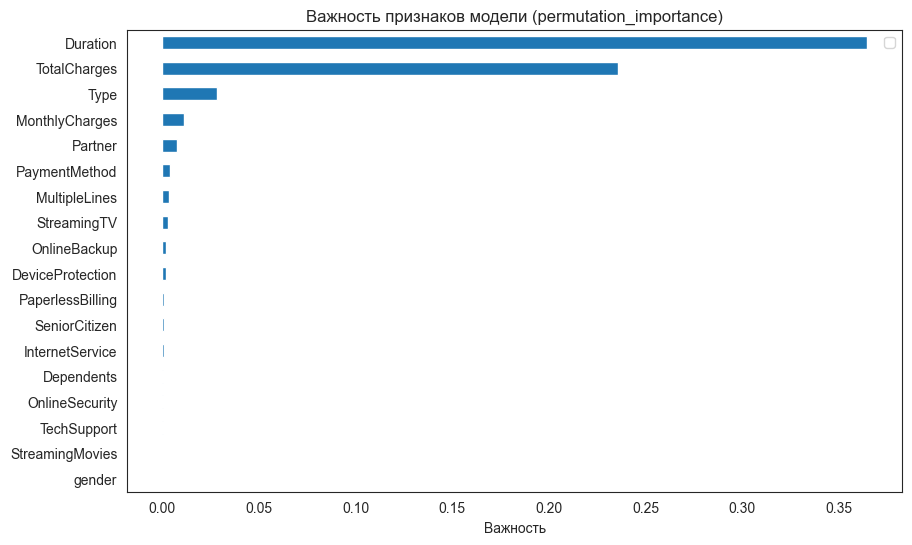

In [35]:
result = permutation_importance(hyper_search, X_test, y_test, scoring='roc_auc', n_repeats=15, random_state=RANDOM_STATE)
feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': result['importances_mean']}).sort_values(
    'Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), legend=False)
plt.title('Важность признаков модели (permutation_importance)')
plt.ylabel('')
plt.xlabel('Важность')
plt.legend('')
plt.show()

Теперь вычислим важность признаков с помощью **shap**:

In [36]:
X_test_pre = hyper_search.best_estimator_['columntransformer'].transform(X_test)
feature_names = [x for x in hyper_search.best_estimator_['columntransformer'].get_feature_names_out()]

explainer = shap.KernelExplainer(lambda x: hyper_search.best_estimator_['models'].predict_proba(x)[:, 1],
                                 shap.sample(X_test_pre, 20, random_state=RANDOM_STATE), feature_names=feature_names)

shap_ready = True
filename1 = 'final_project_shap.pkl'
if shap_ready:
    shap_values = pickle.load(open(filename1, 'rb'))
else:
    shap_values = explainer(X_test_pre)
    pickle.dump(shap_values, open(filename1, 'wb'))

Построим график важности признаков. Результат примерно аналогичен предыдущему варианту, однако теперь важность признака  месячных расходов стала меньше:

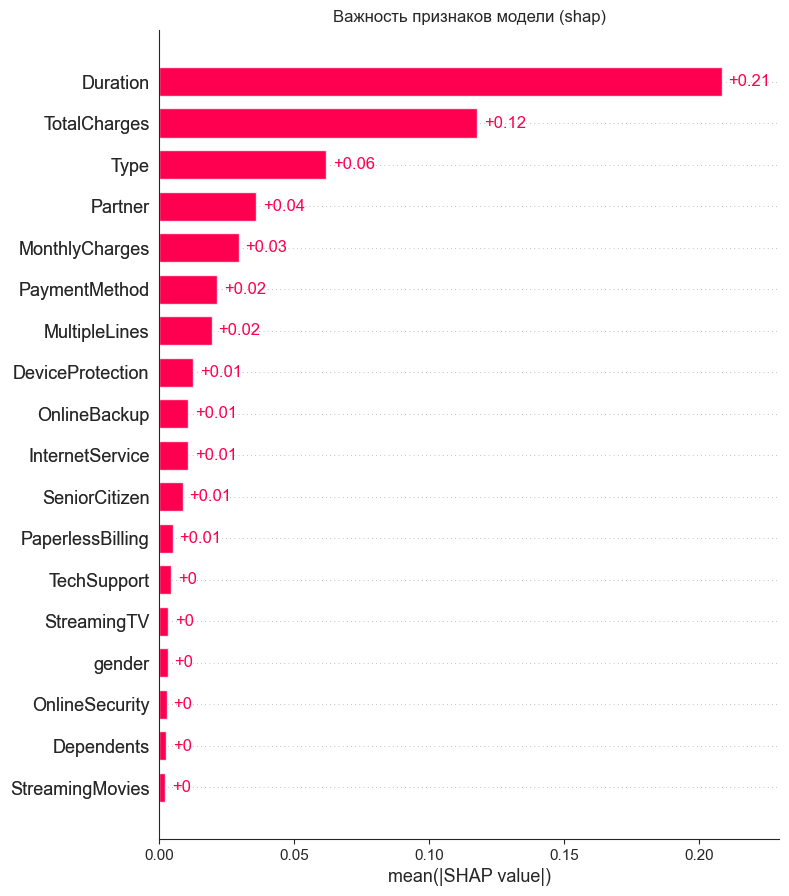

In [37]:
plt.title('Важность признаков модели (shap)')
shap.plots.bar(shap_values, max_display=20)

Теперь проанализируем направление связи предикторов и целевой переменной. Правда, сделать это получится в основном для числовых признаков, так как категориальные признаки подаются на вход модели необработанными. В остальном наблюдаемый эффект соответствует выводам исследовательского анализа: для высокой длительности вероятность разрыва контракта скорее снижается, а для средней длительности - повышается. Относительно общих расходов можно сказать, что низкие значения скорее снижают вероятность разрыва контракта, а остальные значения оказывают смешанное влияние. Наблюдается и самый очевидный эффект: высокие месячные расходы скорее повышают вероятность разрыва контракта и наоборот. Наконец, пенсионеры чуть более склонны разрывать контракт.

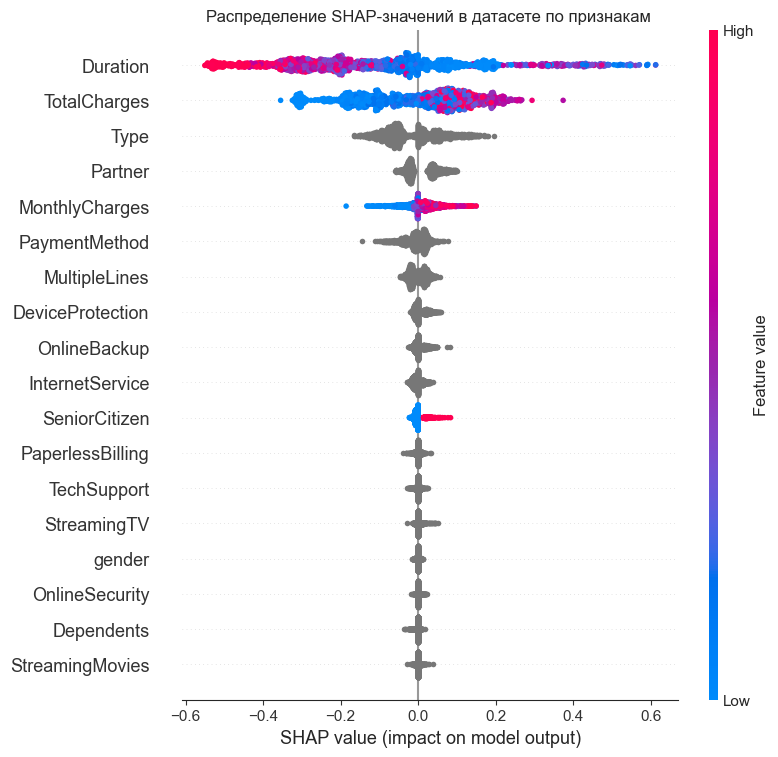

In [38]:
plt.title('Распределение SHAP-значений в датасете по признакам ')
shap.plots.beeswarm(shap_values, max_display=20)

<a id="9"></a>

## Общий вывод и рекомендации заказчику

По ходу работы были проделаны следующие этапы:
1. Загрузка датасетов: 4 набора данных с количеством записей от 5500 до 7000; типы данных в некоторых случаях не совпали с ожидаемыми.
2. Предобработка: пропусков не выявлено, исправлены типы переменных *SeniorCitizen* и *TotalCharges*, столбцы с датами *BeginDate* и *EndDate* заменены на целевой столбец и столбец с количеством дней с момента заключения договора. Удалены 11 неявных пропусков в столбце TotalCharges. В зависимой переменной имеет место дисбаланс классов: расторгнутых контрактов заметно меньше (16%).
3. Исследовательский анализ: месячные расходы имеют пик в районе 30, а в остальном нормально распределены. Плотность распределения общих расходов монотонно снижается, а длительность контракта имеет два пика по краям с просадкой по середине. Среди категориальных признаков большая часть бинарна. Аномалий среди значений и их частот не обнаружено. При исследовании относительно целевого признака было выявлено, что среди разорванных контрактов чаще встречаются клиенты с высокими месячными расходами, а наиболее высокие и наиболее низкие значения общих расходов чаще свойственны для действующих контрактов. Распределение длительности контракта имеет схожий характер с общими расходами: два пика по краям для действующих контрактов и пик в центре (1000 дней) для разорванных. Кроме того, клиенты в браке и с дополнительными услугами в целом чаще расторгали контракт.
4. Объединение датасетов: итоговый размер данных: 7032  записи. Вместе с тем, в присоединённых данных о телефонных и интернет-услугах были пропуски, так как не у всех клиентов эти услуги подключены. Эти пропуски были заменены заглушкой.
5. Исследовательский анализ объединённых данных: свойства распределения интервальных переменных остались теми же. В распределение категориальных признаков добавилась категория заглушки, но в целом свойства только усилились: клиенты в браке и пользующиеся дополнительными услугами чаще расторгали контракт.
6. Корреляционный анализ (метод phik): было выявлено, что корреляция между столбцами с интернет-услугами заметно завышена из-за эффекта заглушки. Помимо этого, столбец с месячными затратами коррелирует с наличием различных услуг, влияющих на абонентскую плату. В особенности это касается интернет-подключения (0,92), стримингового телевидения и кино (0,86). Также признак общей суммы затрат довольно сильно коррелирует с длительностью контракта (0,85) и месячными расходами (0,71); эти же три признака сильнее прочих коррелируют с целевым (0,3; 0,37; 0,23 соответственно). Категориальные признаки в большинстве довольно слабо коррелируют с целевым признаком (с коэффициентом 0,23 и менее), что подтверждалось и на этапе исследовательского анализа. Признак *gender* вообще ни с чем не коррелирует, особенно с целевым признаком, но решение об удалении было отложено на более поздний этап.
7. Построение и оценка модели: соотношение обучающей и тестовой выборки 3 к 1. Протестированы 5 моделей: дерево, метод ближайших соседей, логистическая регрессия, метод опорных векторов и бустинг с указанием параметров модели, позволяющих учитывать дисбаланс классов. Основной метрикой заказчик выбрал **ROC AUC** . Лучшей моделью оказался метод бустинга Catboost с масштабированием **RobustScaler**, 1200 деревьев с глубиной 2 каждое и параметрами **l2_leaf_reg**=0,2, **learning_rate**=0,2, без балансировки классов. Метрика при кросс-валидации: **roc auc**=0,928. Попытка удалить 3 наименее значимых признака не привела к улучшению метрики, итоговая модель осталась прежней. Её результат на тесте **roc auc**=0,949. Показатель хороший, дополнительные метрики показывают следующие значения: **F1**=0,794 при **precision**=0,940 и **recall**=0,687. Это означает, что классификация проходит в целом довольно качественно, но именно целевой признак предсказывется не столь хорошо (ошибка первого рода происходит с вероятностью примерно 29%). Сравнение с примитивной моделью (равномерное распределение) показало, что её результат всего лишь **roc auc**=0,5 и сильно уступает основной модели. В целом, это можно считать показателем успешного построения модели.
8. Анализ значимости признаков: важность признаков **permutation_importance** показывает, что 4 основных для предсказания признака, это  длительность, общие расходы, тип оплаты и месячные расходы. При вычислении важности признаков с помощью **shap** выводы аналогичные, но так же довольно значимым оказывается то, состоит ли клиент в браке. При анализе направления связи предикторов и целевой переменной заметно, что для высокой длительности вероятность разрыва контракта скорее снижается, а для средней длительности - повышается. Относительно общих расходов можно сказать, что низкие значения скорее снижают вероятность разрыва контракта, а остальные значения оказывают смешанное влияние. Высокие месячные расходы скорее повышают вероятность разрыва контракта и наоборот. Наконец, пенсионеры чуть более склонны разрывать контракт.  

На основе имеющихся данных сложно дать конкретные рекомендации для бизнеса, так как почти все предоставленные данные значимо не влияют на целевой признак. В целом, можно сделать вывод, что на лояльность клиента не влияет конкретный набор услуг, которыми он пользуется, а важно лишь то, как много он в итоге платит в месяц, как давно заключил контракт и сколько суммарно потратил денег за всё время. Возможно, это говорит о том, что работа технической поддержки находится на не слишком высоком уровне, так как подключение выделенной линии не позволяет дополнительно удерживать клиентов. Кроме того, основная масса разорванных контрактов имеют длительность от 500 до 1500 дней, именно на таких клиентов, вероятно, стоит обратить особое внимание, так как они уже заметное время пользуются услугами и важны для компании, но являются потенциально ненадёжными. Возможно, стоит ввести отдельную систему с баллами за лояльность или акциями, связанными с длительностью пользования услугами. Кроме того, использование построенной в рамках проекта модели позволяет выявлять склонных к уходу клиентов и предлагать им персональные акции. Среди личных характеристик клиентов, можно отметить, что пенсионеры и состоящие в браки чуть чаще разрывают контракт. Возможно, стоит ввести отдельные акции и для этих категорий. Наконец, уточнение требований заказчиком могло бы позволить создать более адаптированную под конкретный бизнес модель. Так, стоит определится, какая ошибка для бизнеса более критична с точки зрения потери прибыли (попытка удержать клиента, который не собирался уходить, или неудержание клиента, который был близок к разрыву контракта) и в каком отношении. Это понимание позволит задействовать F-метрику с нужным соотношением **precision**-**recall**.

<a id="10"></a>

## Дополнительное задание: расчёт убытков

Чтобы посчитать прибыль, рассмотрим такую схему:    
- если клиент на самом деле был лояльный, то мы потеряли 30% (константа *PROMO*) от стоимости месячного платежа (ошибка первого рода)
- если клиент был отточный, а мы не дали ему промокод, то мы потеряем 100% от стоимости ежемесячного платежа (ошибка второго рода).    


Для начала, ещё раз построим лучшую модель и посчитаем для неё метрики:

In [39]:
col_transformer1 = make_column_transformer(
    (
        RobustScaler(), 
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

params = {
    'depth': 2,
    'iterations': 1500,
    'l2_leaf_reg': 0.2,
    'learning_rate': 0.2,
    'auto_class_weights': 'None',
    'verbose': 0,
}

PROMO = 0.3

In [40]:
params['cat_features'] = ohe_features
model = CatBoostClassifier(**params)
cv_score = cross_val_score(model, col_transformer1.fit_transform(X_train), y_train, verbose=3, scoring='roc_auc').mean()
print(f'Метрика roc auc на кросс-валидации: {cv_score:.3f}')

model.fit(X_train, y_train)
roc_pred = model.predict(X_test)

[CV] END ................................ score: (test=0.920) total time=   8.6s
[CV] END ................................ score: (test=0.944) total time=   7.8s
[CV] END ................................ score: (test=0.921) total time=   7.9s
[CV] END ................................ score: (test=0.944) total time=   7.5s
[CV] END ................................ score: (test=0.921) total time=   7.6s
Метрика roc auc на кросс-валидации: 0.930


In [41]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(f'Метрика roc auc на тестовой выборке: {roc_auc_score(y_test, y_pred_proba):.3f}')
print(f'Метрика fbeta на тестовой выборке: {fbeta_score(y_test, roc_pred, beta=1/PROMO):.3f}')
print(f'Метрика precision на тестовой выборке: {precision_score(y_test, roc_pred):.3f}')
print(f'Метрика recall на тестовой выборке: {recall_score(y_test, roc_pred):.3f}')


Метрика roc auc на тестовой выборке: 0.948
Метрика fbeta на тестовой выборке: 0.704
Метрика precision на тестовой выборке: 0.983
Метрика recall на тестовой выборке: 0.687


Теперь найдём оптимум для решётки параметров с точки зрения метрики **fbeta**, где **beta** равна отношению единицы к *PROMO*:

In [42]:
param_grid1 = [
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=0, cat_features=ohe_features, loss_function='Logloss')],
        'models__depth': [2],
        'models__iterations': [1200, 1500],
        'models__l2_leaf_reg': [0.1, 0.2, 0.3],
        'models__learning_rate': [0.2, 0.3],
        'models__auto_class_weights': ['None',],       
        'columntransformer__onehotencoder': ['passthrough'],
        'columntransformer__scaler': [RobustScaler()],
    },
]

In [43]:
fbeta_scorer = make_scorer(fbeta_score, beta=1/PROMO)
hyper_search1 = GridSearchCV(
    pipeline_model, 
    param_grid=param_grid1, 
    scoring=fbeta_scorer, 
    n_jobs=-1,
    verbose=3,
)
hyper_search1.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'Dev...
             param_grid=[{'columntransformer__onehotencoder': ['passthrough'],
                          'columntransformer__scaler': [RobustScaler()],
                          'models': [<catboost.core.CatBoostClassifier object at 0x000002313F03AC90>],
                          'models__auto_class_weights': ['None'],
                          'models__depth': [2],
                          'models__iterations': [1200, 1500],
                          'models__l2_leaf_reg': [0.1, 0.2, 0.3],
                          'models__learning_rate': [0.2, 0.3]}],
             scoring=make_scorer(fbeta_score, beta=3.3333333333333335),
             verbose=3)

Посчитаем результат на кросс-валидации и тесте. Как и следовало ожидать, на тесте, в сравнении с предыдущим решением,  **recall** слегка повысился (с 0,671 до 0,707) за счёт более сильного снижения **precision** (с 0,960 до 0,876).

In [44]:
print(f'{hyper_search1.best_score_:.3f}')
display(hyper_search1.best_estimator_)
hyper_search1.best_params_

0.706


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  'passthrough',
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod', 'gender',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'MultipleLines']),
                                                 ('scaler', RobustScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'Duration'])],
                                   verbose_feature_names_out=False)),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x000002313D554250>)])

{'columntransformer__onehotencoder': 'passthrough',
 'columntransformer__scaler': RobustScaler(),
 'models': <catboost.core.CatBoostClassifier at 0x2313f03ac90>,
 'models__auto_class_weights': 'None',
 'models__depth': 2,
 'models__iterations': 1500,
 'models__l2_leaf_reg': 0.1,
 'models__learning_rate': 0.3}

In [45]:
y_pred = hyper_search1.predict(X_test)
y_pred_proba = hyper_search1.predict_proba(X_test)[:, 1]

print(f'Метрика roc auc на тестовой выборке: {roc_auc_score(y_test, y_pred_proba):.3f}')
print(f'Метрика fbeta на тестовой выборке: {fbeta_score(y_test, y_pred, beta=1/PROMO):.3f}')
print(f'Метрика precision на тестовой выборке: {precision_score(y_test, y_pred):.3f}')
print(f'Метрика recall на тестовой выборке: {recall_score(y_test, y_pred):.3f}')

fbeta_pred = hyper_search1.predict(X_test)

Метрика roc auc на тестовой выборке: 0.948
Метрика fbeta на тестовой выборке: 0.711
Метрика precision на тестовой выборке: 0.888
Метрика recall на тестовой выборке: 0.699


Теперь сделаем предсказание по обеим моделям и посчитаем убытки. В результате модель с оптимизацией fbeta ведёт к большим суммарным убыткам из-за ошибок на примерно 4,5 процента, а значит изначальная модель лучше. Видимо, это связано с тем, что модель fbeta ошибается хоть и чуть реже, но для более прибыльных клиентов:

In [46]:
res = pd.concat([X_test['MonthlyCharges'], y_test], axis=1).reset_index(drop=True)
res['roc_pred'] = roc_pred
res['fbeta_pred'] = fbeta_pred

In [47]:
FP_sum_roc = res.loc[(res['roc_pred']==1) & (res[target]==0), 'MonthlyCharges'].sum()*PROMO
FN_sum_roc = res.loc[(res['roc_pred']==0) & (res[target]==1), 'MonthlyCharges'].sum()
FP_sum_fbeta = res.loc[(res['fbeta_pred']==1) & (res[target]==0), 'MonthlyCharges'].sum()*PROMO
FN_sum_fbeta = res.loc[(res['fbeta_pred']==0) & (res[target]==1), 'MonthlyCharges'].sum()

In [48]:
print('Потери первой модели (оптимум ROC_AUC):')
print(f'Ошибка 1 рода: {FP_sum_roc:.3f}, Ошибка 2 рода: {FN_sum_roc:.3f}, Сумма: {FP_sum_roc + FN_sum_roc:.3f}')
print('Потери второй модели (оптимум fbeta):')
print(f'Ошибка 1 рода: {FP_sum_fbeta:.3f}, Ошибка 2 рода: {FN_sum_fbeta:.3f}, Сумма: {FP_sum_fbeta + FN_sum_fbeta:.3f}')
print(f'Экономия: {1-(FP_sum_fbeta + FN_sum_fbeta)/(FP_sum_roc + FN_sum_roc):.3%}')

Потери первой модели (оптимум ROC_AUC):
Ошибка 1 рода: 45.465, Ошибка 2 рода: 5646.400, Сумма: 5691.865
Потери второй модели (оптимум fbeta):
Ошибка 1 рода: 548.490, Ошибка 2 рода: 5399.750, Сумма: 5948.240
Экономия: -4.504%
